## Utils

In [1]:
def mad_thresholds(data, nmads):
    """
    Calculate thresholds based on the Median Absolute Deviation (MAD).
    
    Parameters:
    - data: array-like, the input data for which thresholds will be calculated.
    - nmads: float, the number of MADs to define the upper and lower limits.
    
    Returns:
    - dict with median, upper limit, and lower limit.
    """
    import numpy as np
    import astropy.stats as ap
    
    # Calculate median and MAD-based thresholds
    m = np.median(data)
    mad = ap.median_absolute_deviation(data)
    upper = m + nmads * mad
    lower = m - nmads * mad
    
    # Return rounded thresholds
    return {"median": np.round(m, 3), "upper_limit": np.round(upper, 3), "lower_limit": np.round(lower, 3)}

def mad_filter(adata, feature, nmads):
    """
    Identify outliers in a feature based on MAD thresholds.
    
    Parameters:
    - adata: AnnData object, contains the dataset.
    - feature: str, the name of the feature in adata.obs to analyze.
    - nmads: float, the number of MADs to define outlier thresholds.
    
    Returns:
    - pd.Series (bool) indicating whether each observation is an outlier.
    """
    import numpy as np
    
    # Extract the feature distribution
    f_distr = adata.obs[feature]
    
    # Compute MAD thresholds
    th = mad_thresholds(f_distr, nmads)
    
    # Identify outliers
    outlier = (f_distr < th["lower_limit"]) | (f_distr > th["upper_limit"])
    
    return outlier

## Pre-processing and clusters annotation

In [2]:
# key packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from scipy import stats
from scipy.sparse import csr_matrix
import anndata
import skimage
import decoupler as dc
import gseapy as gp
# other
import astropy.stats as ap
from sklearn.metrics import silhouette_score
import csv as cs
import os
import itertools
import matplotlib.colors as clrs
from IPython.core.display import display, HTML

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2746583/2676768897.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# scanpy settings
sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=150)
sc.logging.print_versions()

-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                 10.4.0
astropy             6.1.4
asttokens           NA
bottleneck          1.3.7
brotli              NA
certifi             2024.08.30
cffi                1.15.1
charset_normalizer  2.0.4
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
decoupler           1.8.0
erfa                2.0.1.4
exceptiongroup      1.2.0
executing           0.8.3
gseapy              1.1.3
h5py                3.12.1
idna                3.4
igraph              0.11.6
ipykernel           6.28.0
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.7
lazy_loader         0.4
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
matplotlib          3.9.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.8.7
numpy     

In [4]:
# color map definition called cm2 (gray background with red dots for Umap)
colors = [(0, ("#E0E0E0")), (0.25, ("#F1F1F1")), (1,("#FD0D0D"))]
n_bins = 250 # discretizes the interpolation into bins
cmap_name = "new_list"
cm_2 = clrs.LinearSegmentedColormap.from_list(cmap_name, colors , N = n_bins)

In [5]:
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [6]:
sc_data_path = "/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/"
clinical_info_path = "/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/clinical.cart.2024-07-31/"
output_dir = "/home/raffaele.iannuzzi/output/"

In [7]:
dir_list = os.listdir(sc_data_path)

In [8]:
dir_list

['C3L-03968',
 'C3N-02784',
 'C3N-02769',
 'C3L-02705',
 'C3N-01814',
 'C3N-01816',
 'C3N-00662',
 'C3N-01798',
 'C3N-01334',
 'C3N-02190',
 'C3N-03184',
 'C3N-02783',
 'C3N-01815',
 'C3N-03186',
 'C3L-03405',
 'C3N-02188',
 'C3N-02181',
 'C3N-03188']

In [9]:
genes = pd.read_csv("/home/raffaele.iannuzzi/notebooks/add3_gbm_analysis/protein-coding_gene.txt", delimiter="\t")
genes = genes["symbol"].to_list()
adata_list = []
for sample in dir_list:
    path_to_mtx = os.path.join(sc_data_path, sample, "raw_feature_bc_matrix")
    print(path_to_mtx)
    adata = sc.read_10x_mtx(path_to_mtx, var_names="gene_symbols", cache=True)
    genes_to_keep = [gene for gene in genes if gene in adata.var_names]
    adata_list.append(adata[:, genes_to_keep])

/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3L-03968/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3L-03968-raw_feature_bc_matrix-matrix.h5ad


/tmp/ipykernel_2746583/2983928139.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  genes = pd.read_csv("/home/raffaele.iannuzzi/notebooks/add3_gbm_analysis/protein-coding_gene.txt", delimiter="\t")
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-02784/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-02784-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-02769/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-02769-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3L-02705/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3L-02705-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-01814/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-01814-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-01816/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-01816-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-00662/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-00662-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-01798/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-01798-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-01334/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-01334-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-02190/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-02190-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-03184/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-03184-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-02783/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-02783-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-01815/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-01815-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-03186/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-03186-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3L-03405/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3L-03405-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-02188/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-02188-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-02181/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-02181-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/TCGA_GBM_SC/cases/C3N-03188/raw_feature_bc_matrix
... reading from cache file cache/group-iorio-Raffaele-Project_ADD3-review-TCGA-Single Cell-TCGA_GBM_SC-cases-C3N-03188-raw_feature_bc_matrix-matrix.h5ad


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [10]:
# basic pre-processing
for adata in adata_list:
    print("Before \n{}".format(adata))
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=5)
    print("After \n{}".format(adata))

Before 
View of AnnData object with n_obs × n_vars = 1266604 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1225577 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2728 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 41027 × 16176
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1608572 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1578556 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2364 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 30016 × 16540
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1812511 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1775767 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2526 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 36744 × 16378
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1873917 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1810705 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2112 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 63212 × 16792
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1972241 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1955195 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 1966 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 17046 × 16938
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 2920423 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 2852610 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 1918 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 67813 × 16986
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1103347 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1089829 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2423 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 13518 × 16481
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1970196 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1894857 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 1867 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 75339 × 17037
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1493552 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1470341 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2537 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 23211 × 16367
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1119501 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1105881 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 3192 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 13620 × 15712
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1654382 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1576231 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2592 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 78151 × 16312
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1361552 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1339044 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2123 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 22508 × 16781
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1568902 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1524707 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2206 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 44195 × 16698
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1084187 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1075316 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2797 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 8871 × 16107
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1910890 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1877771 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2418 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 33119 × 16486
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 2331339 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 2272692 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 2250 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 58647 × 16654
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 2257233 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 2182693 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 1866 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 74540 × 17038
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
Before 
View of AnnData object with n_obs × n_vars = 1976985 × 18904
    var: 'gene_ids', 'feature_types'
filtered out 1959322 cells that have less than 200 genes expressed


/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


filtered out 1919 genes that are detected in less than 5 cells
After 
AnnData object with n_obs × n_vars = 17663 × 16985
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


In [11]:
# Quality control N of GENES per cell
for adata in adata_list:
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True)

In [ ]:
# Quality control MITOCHONDRIAL: for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is necessary as X is sparse to transform to a dense array after summing
#for adata in adata_list:
#    adata.var["mito_gene"] = [name.startswith("MT-") for name in adata.var_names]
#    adata.obs["percent_mito"] = (
#        np.sum(
#            adata[:, adata.var["mito_gene"]].X, axis=1).A1 / 
#        np.sum(adata.X, axis=1).A1 
#    )*100

In [ ]:
# Quality control RIBOSOMAL: for each cell compute fraction of counts in ribo genes vs. all genes
#for adata in adata_list:
#    adata.var["ribo_gene"] = [name.startswith(("RPL","RPS")) for name in adata.var_names]
#    adata.obs["percent_ribo"] = (
#        np.sum(
#            adata[:, adata.var["ribo_gene"]].X, axis=1).A1 / 
#        np.sum(adata.X, axis=1).A1
#    )*100

In [ ]:
groups = ["total_counts", "n_genes", "pct_counts_ribo", "pct_counts_mt"]

for i, adata in enumerate(adata_list):
    print(dir_list[i])
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for j, g in enumerate(groups):  
        if g == "n_genes":
            sns.histplot(adata.obs[g], fill=True, ax=axes[j])
            axes[j].set_xlim(0, 8000)
            axes[j].set_xlabel("number of genes per cell")
            axes[j].set_ylabel("frequency")
        elif g == "total_counts":
            sns.histplot(adata.obs[g], fill=True, ax=axes[j])
            axes[j].set_xlim(0, 20000)
            axes[j].set_xlabel("total counts per cell")
            axes[j].set_ylabel("frequency")
        elif g == "pct_counts_ribo":
            sns.histplot(adata.obs[g], fill=True, ax=axes[j])
            axes[j].set_xlim(0, 100)
            axes[j].set_xlabel("% ribo genes per cell")
            axes[j].set_ylabel("frequency")
        elif g == "pct_counts_mt":
            sns.histplot(adata.obs[g], fill=True, ax=axes[j])
            axes[j].set_xlim(0, 100)
            axes[j].set_xlabel("% mito genes per cell")
            axes[j].set_ylabel("frequency")
    plt.tight_layout()  
    plt.show()


## discard very low-quality datasets

In [12]:
samples = ["C3N-01814", "C3N-00662", "C3N-02190", "C3N-02783", "C3N-03186", "C3N-03188"]

In [13]:
adata_list_selected = dict()
for i, adata in enumerate(adata_list):
    if dir_list[i] in samples:
        adata_list_selected[dir_list[i]] = adata

In [14]:
features = ["n_genes", "total_counts", "pct_counts_mt"]

C3N-01814


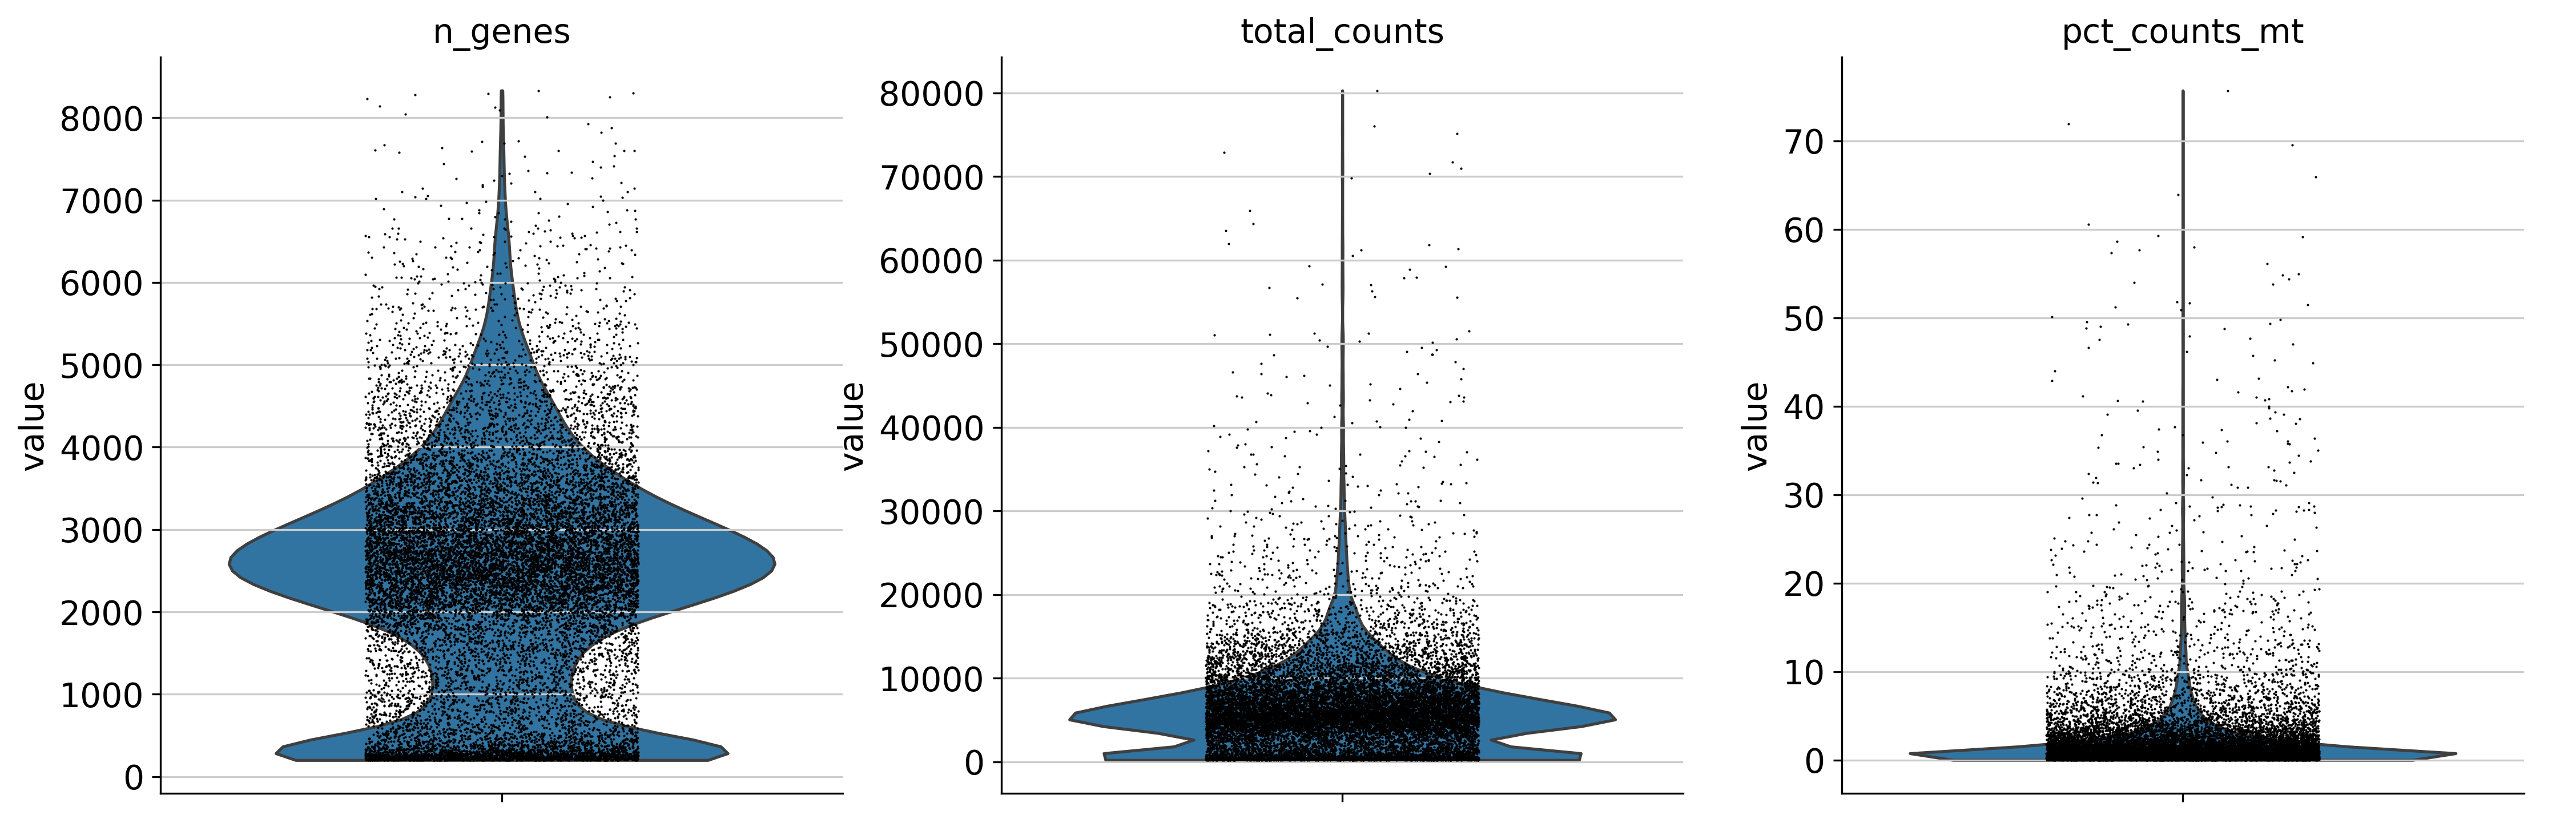

C3N-00662


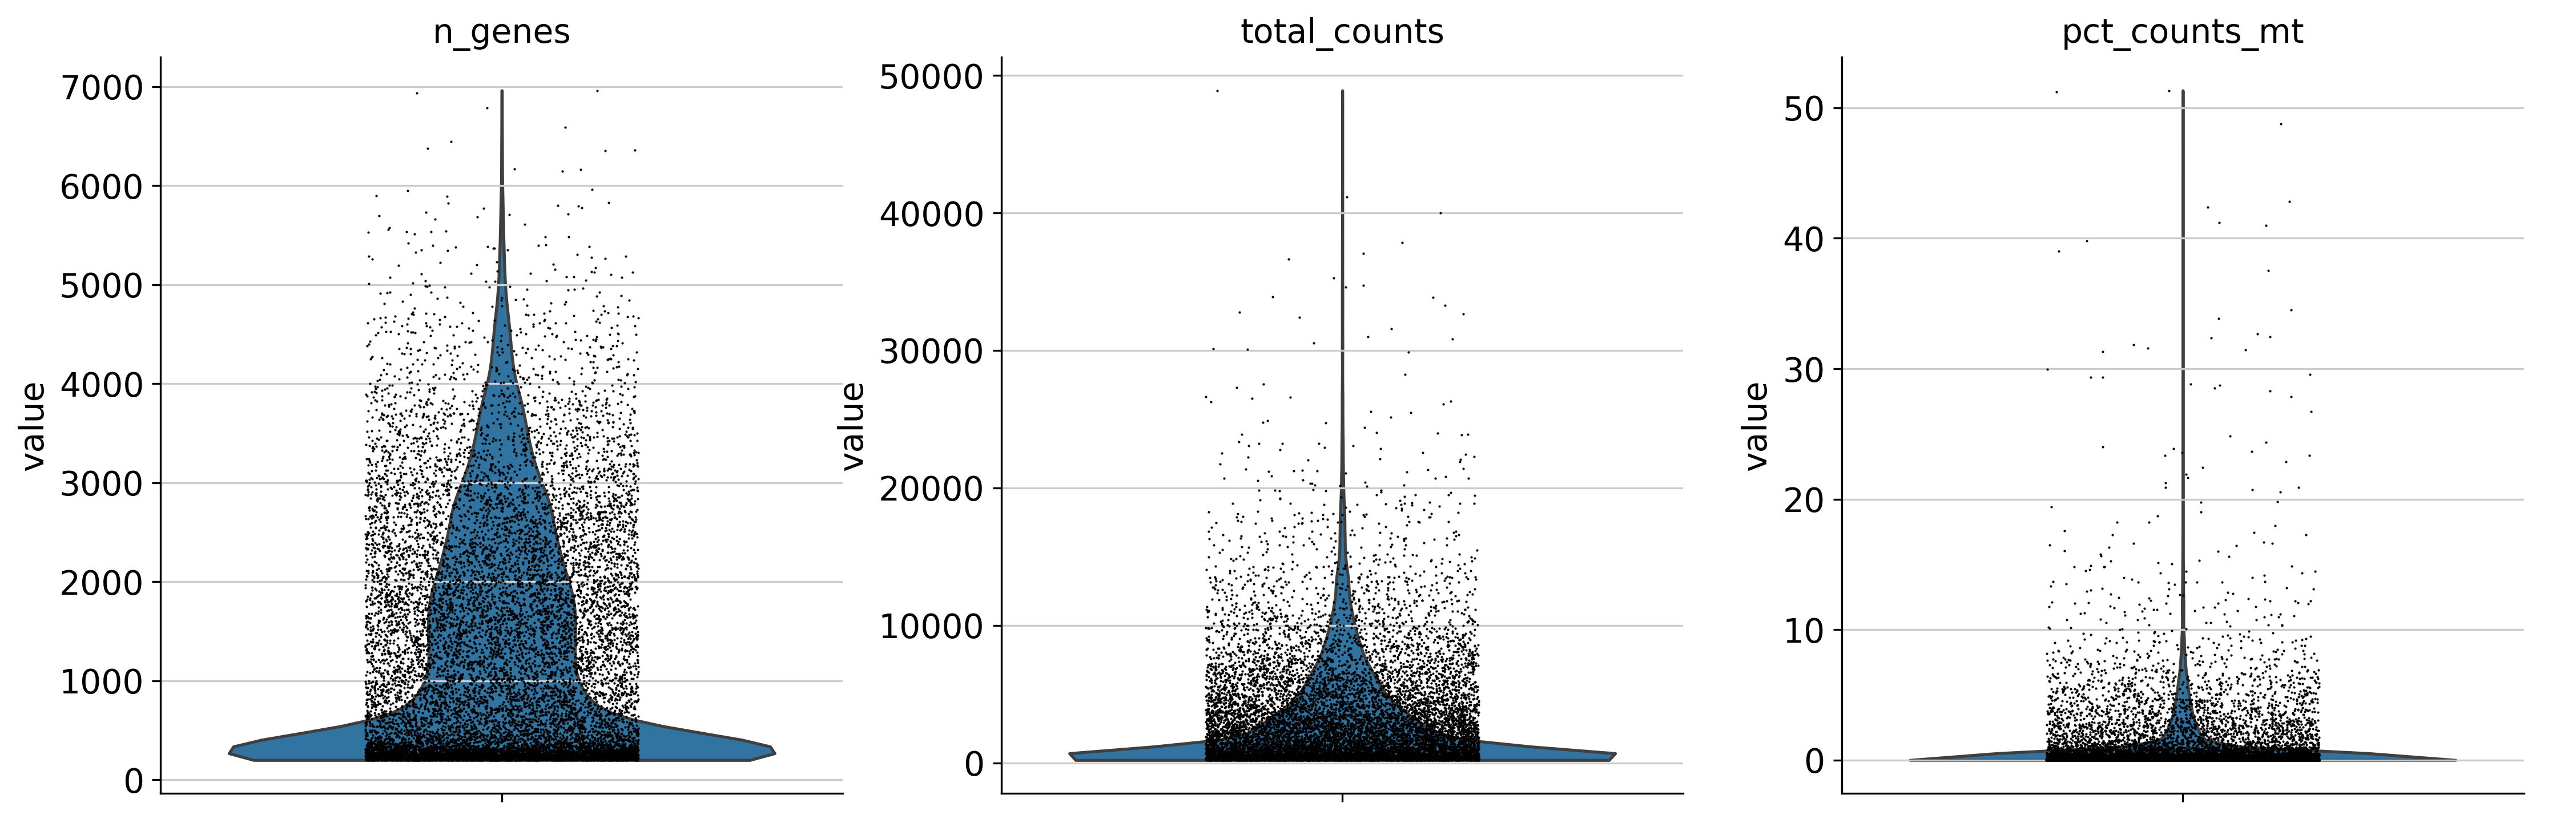

C3N-02190


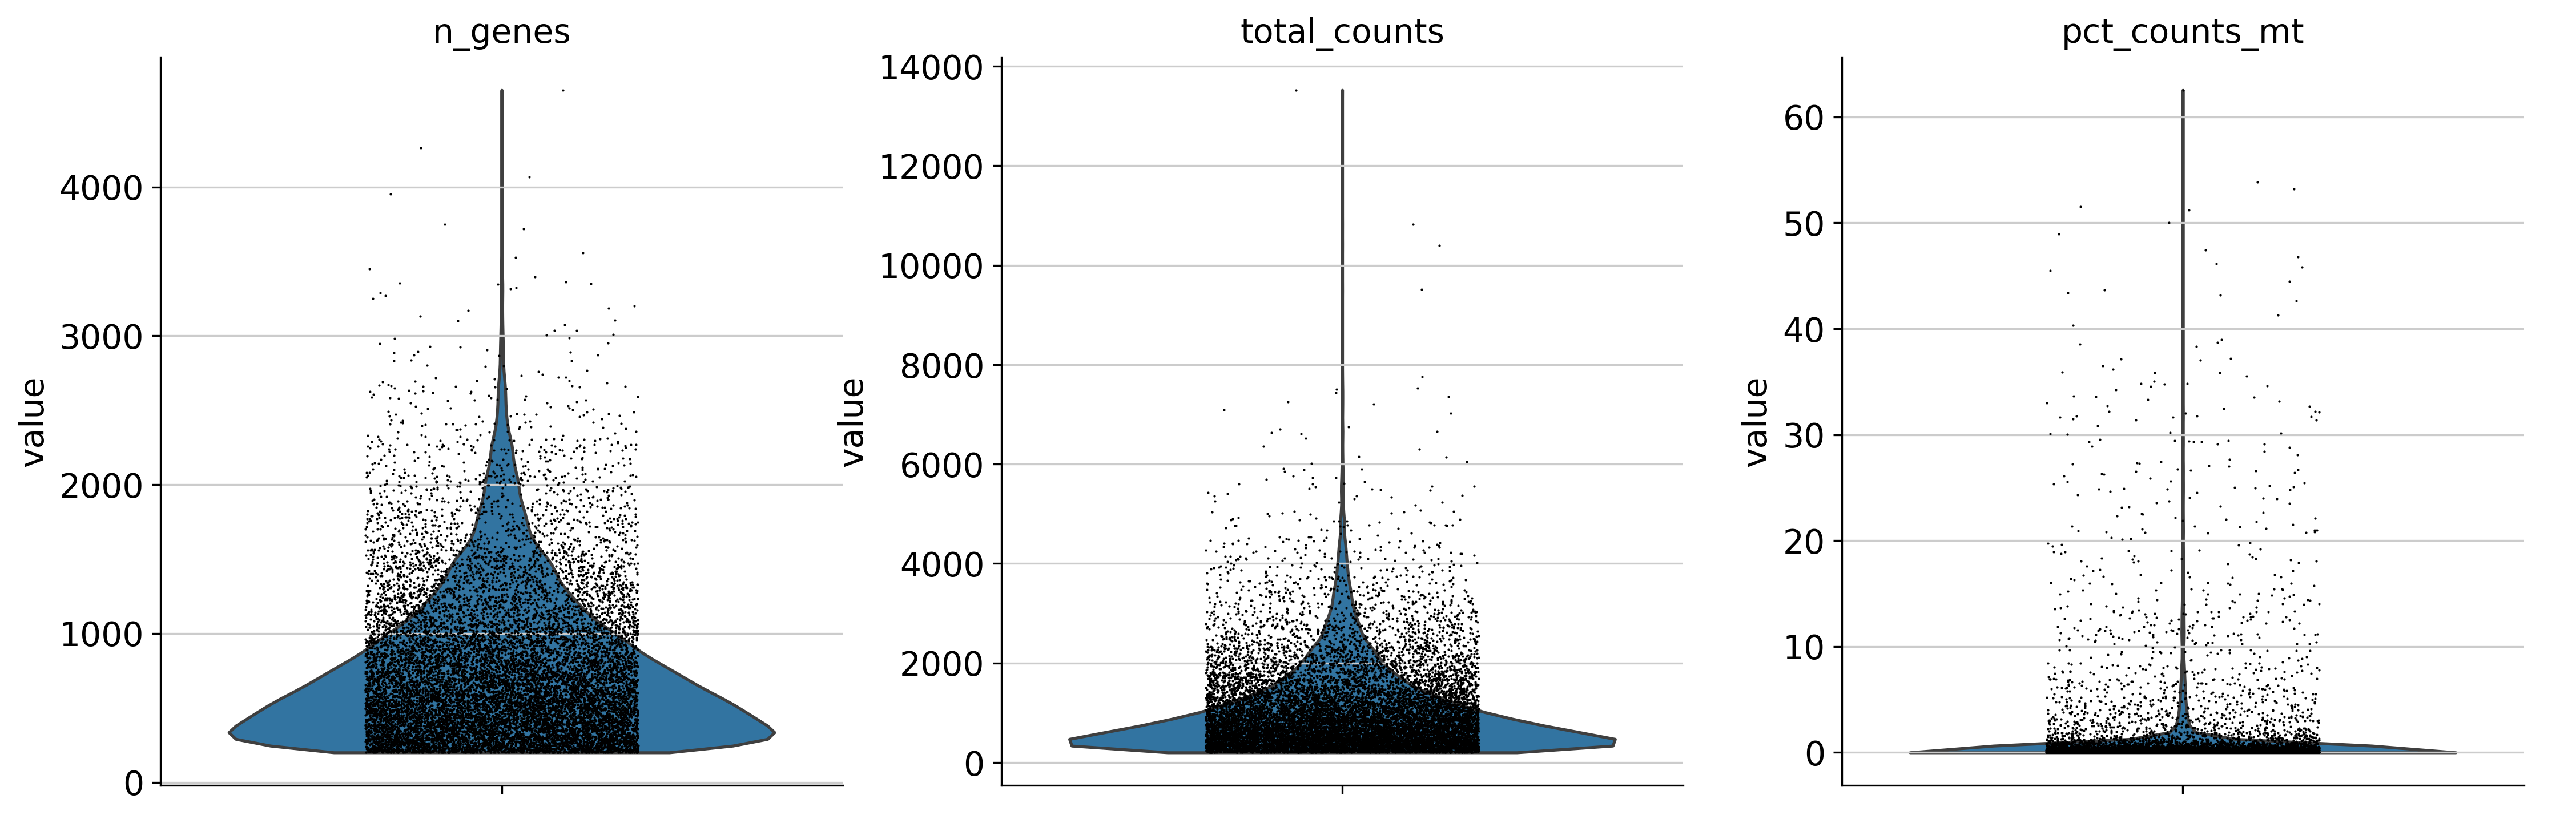

C3N-02783


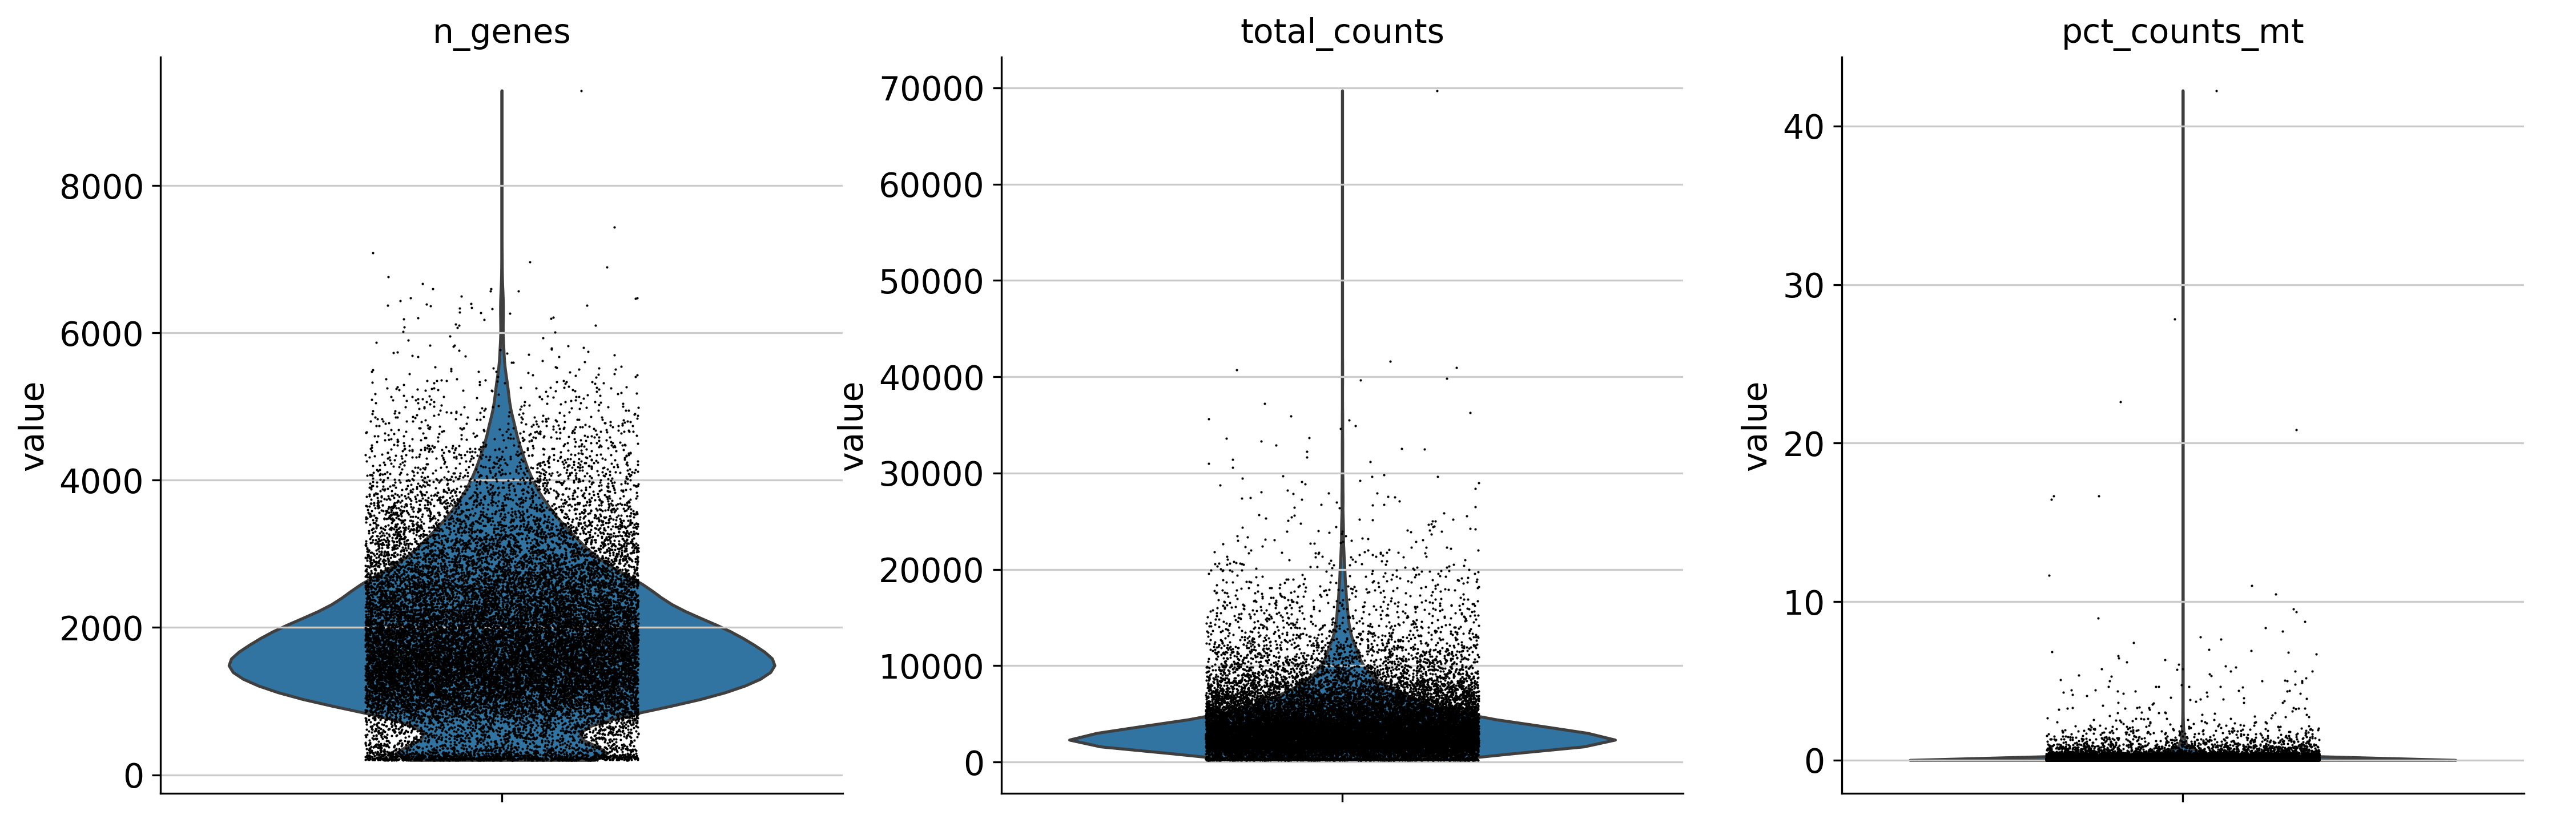

C3N-03186


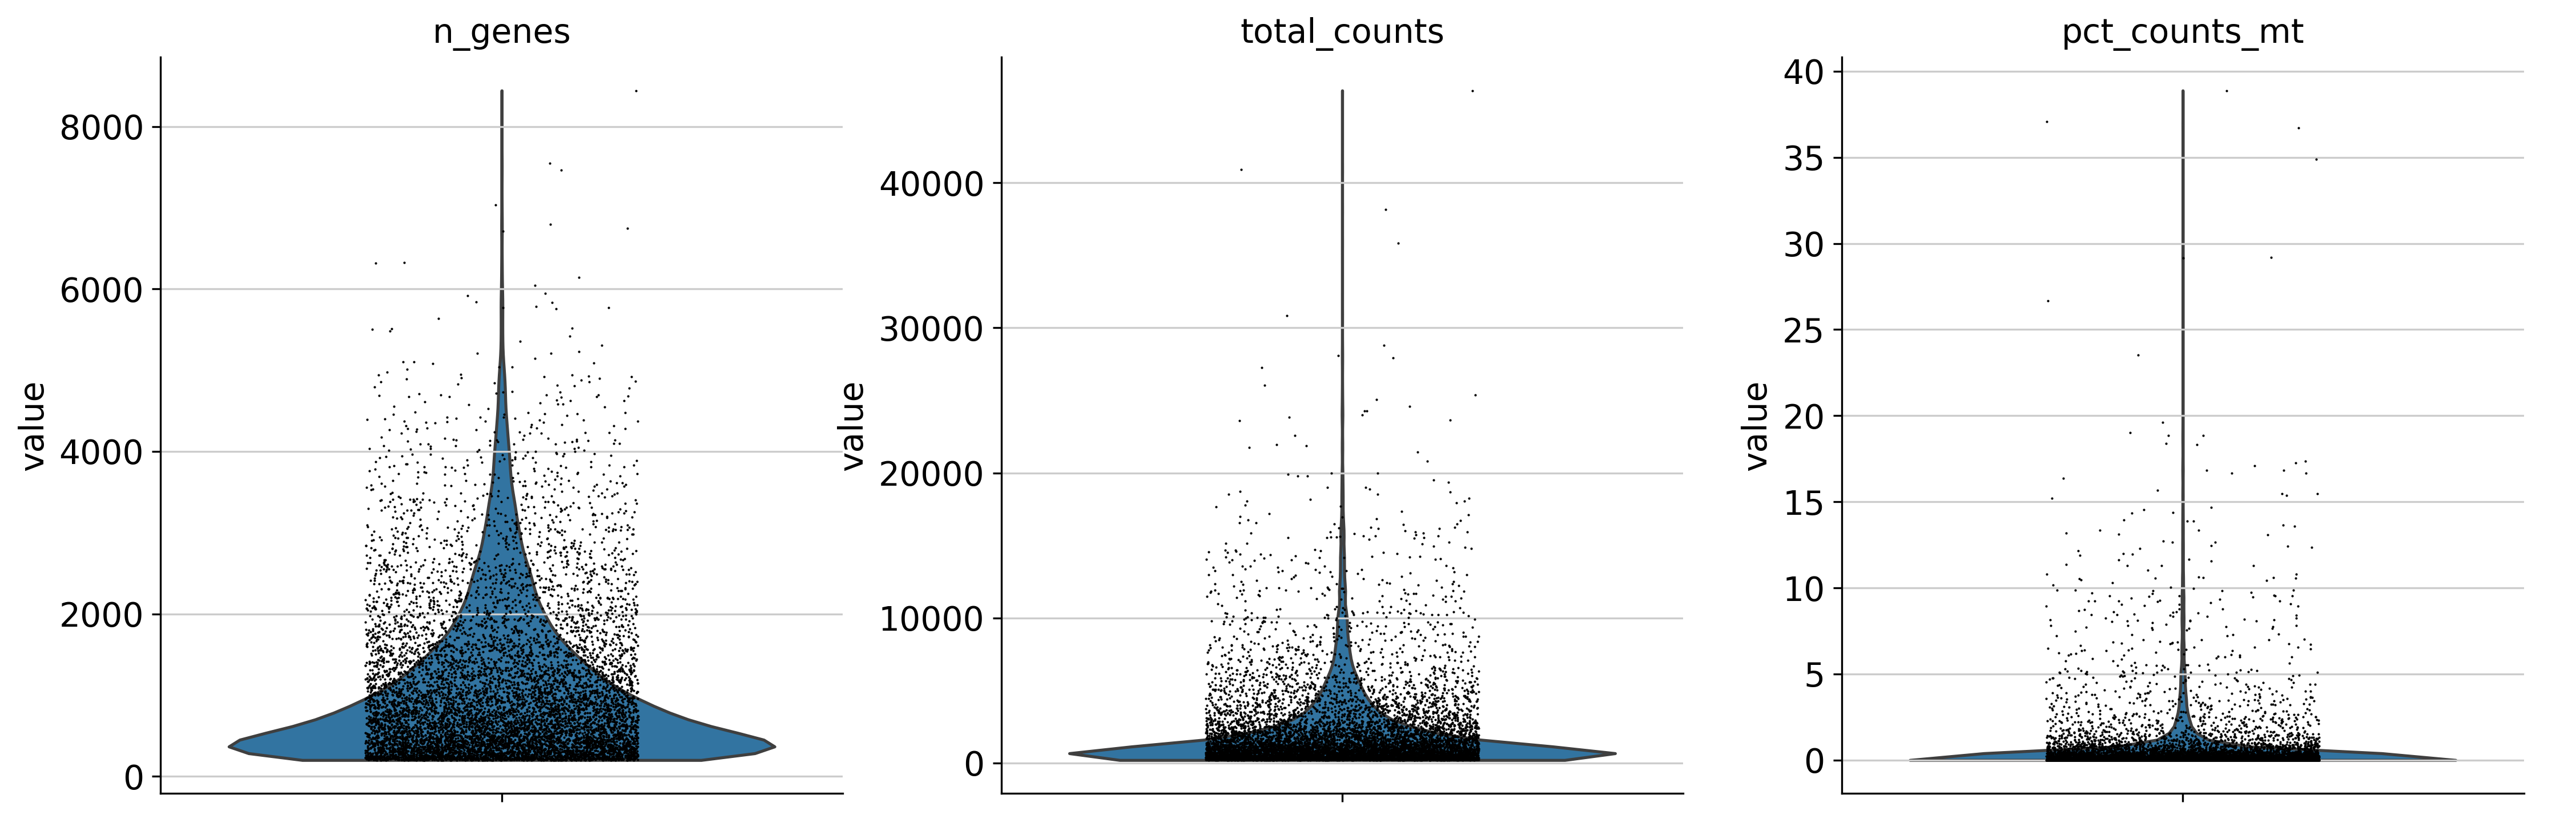

C3N-03188


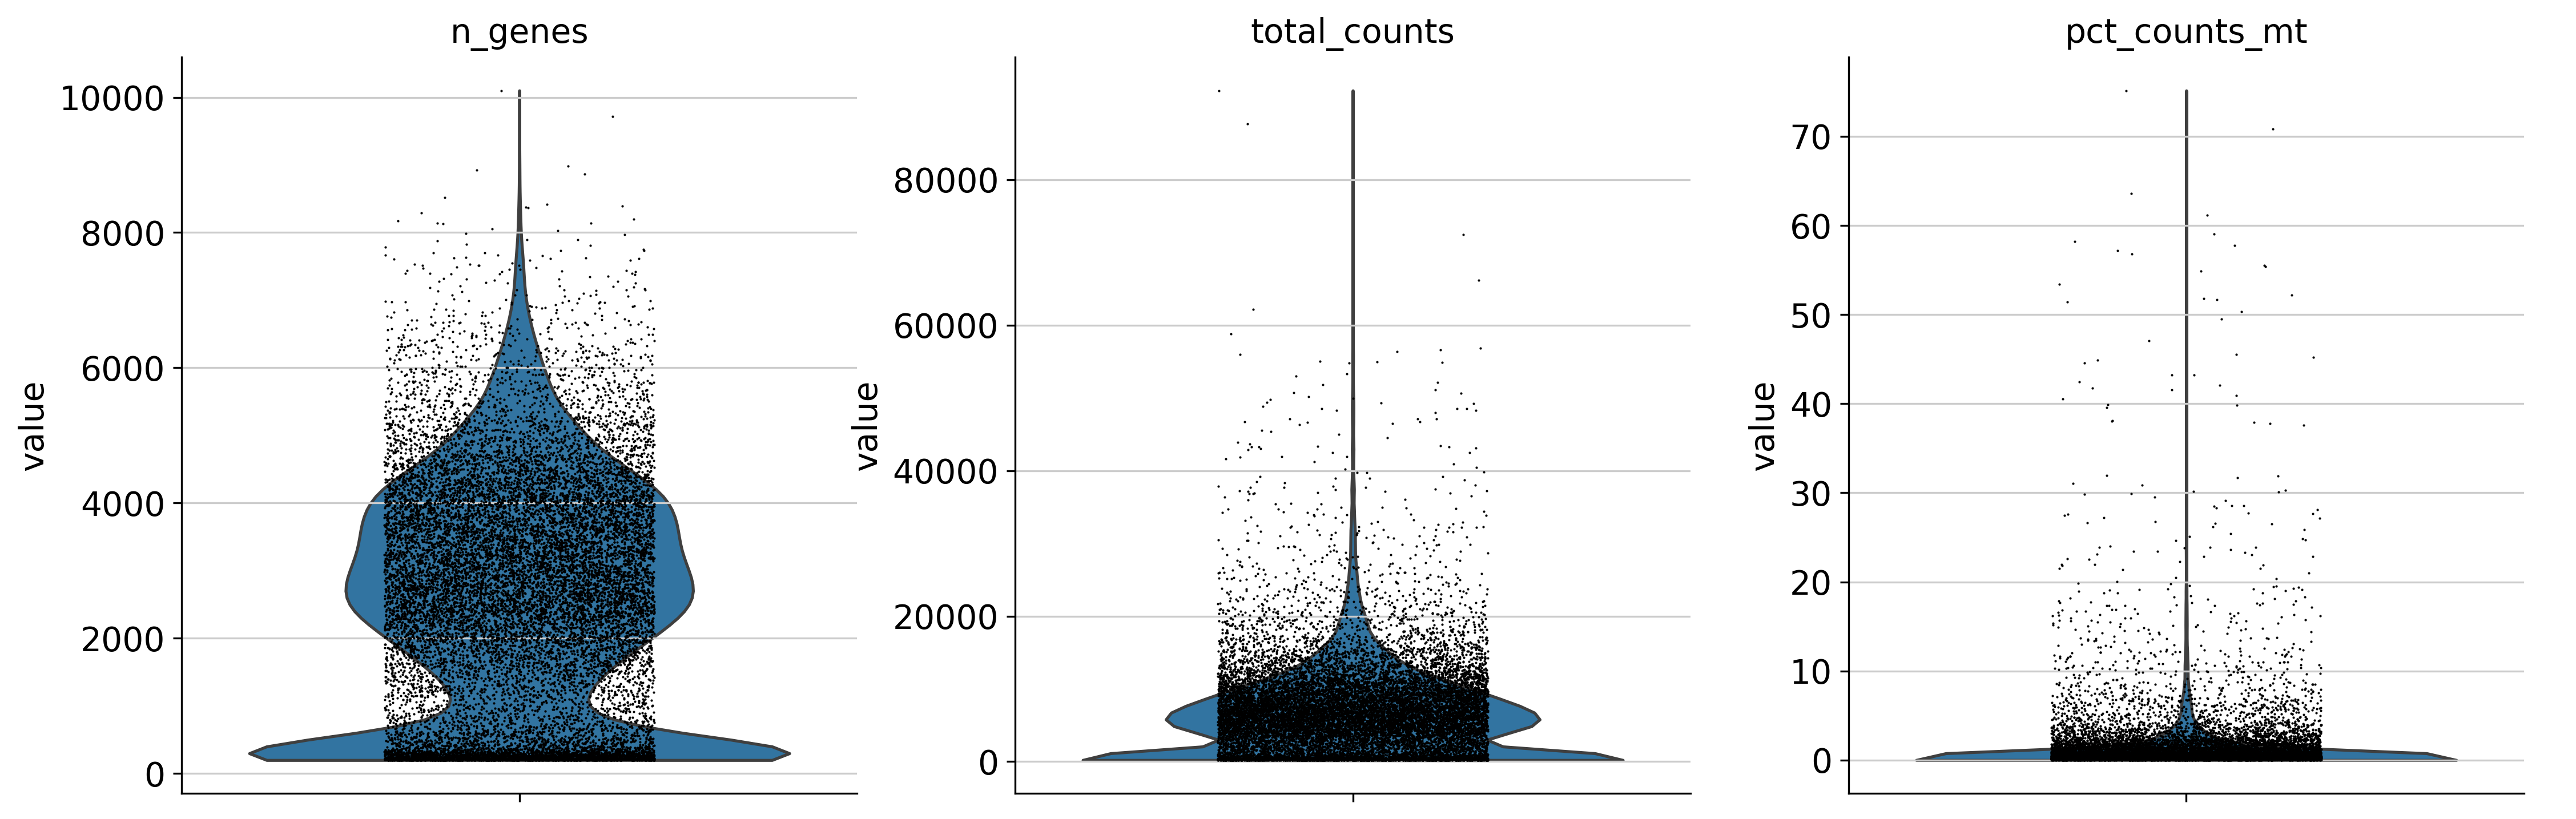

In [15]:
# plot distributions
for k, adata in adata_list_selected.items():
    print(k)
    sc.pl.violin(adata, keys=features, jitter=0.2, multi_panel=True)

C3N-01814
C3N-00662
C3N-02190
C3N-02783
C3N-03186
C3N-03188


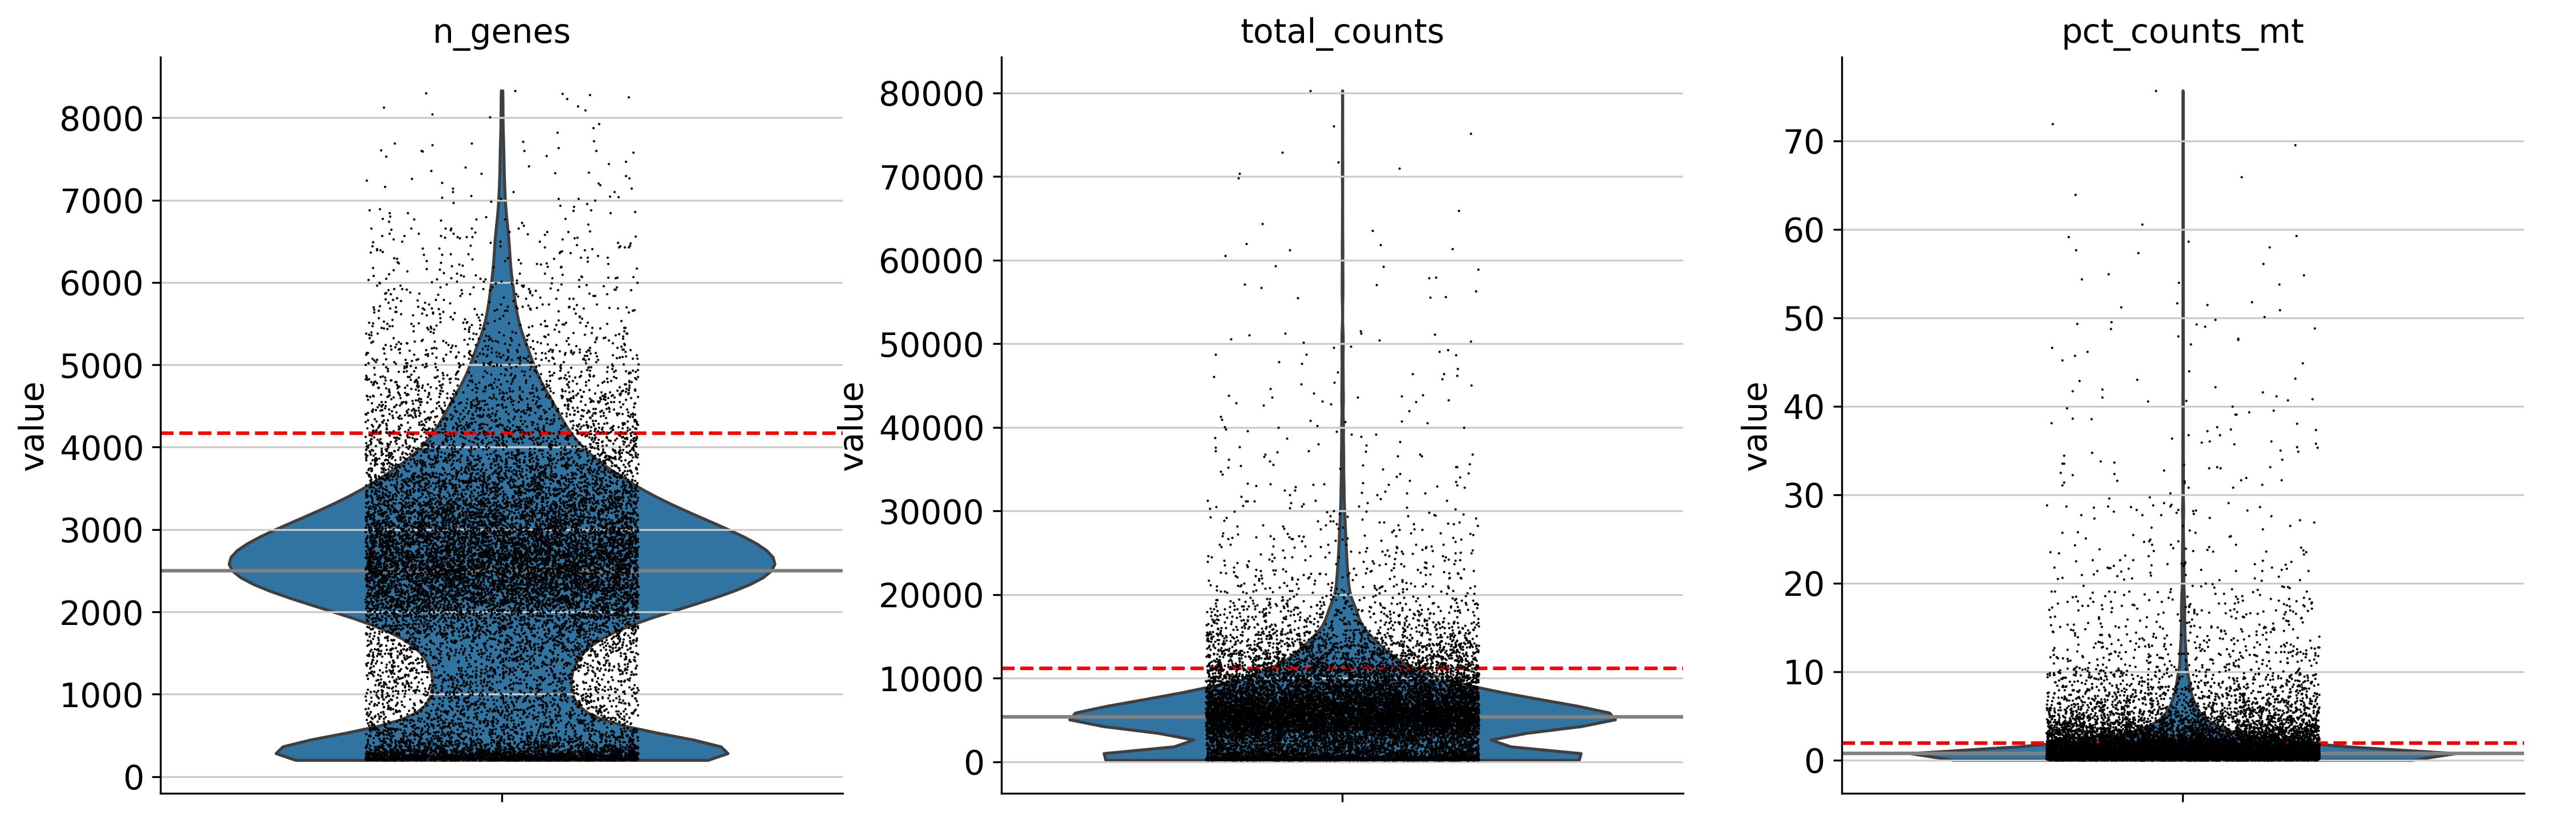

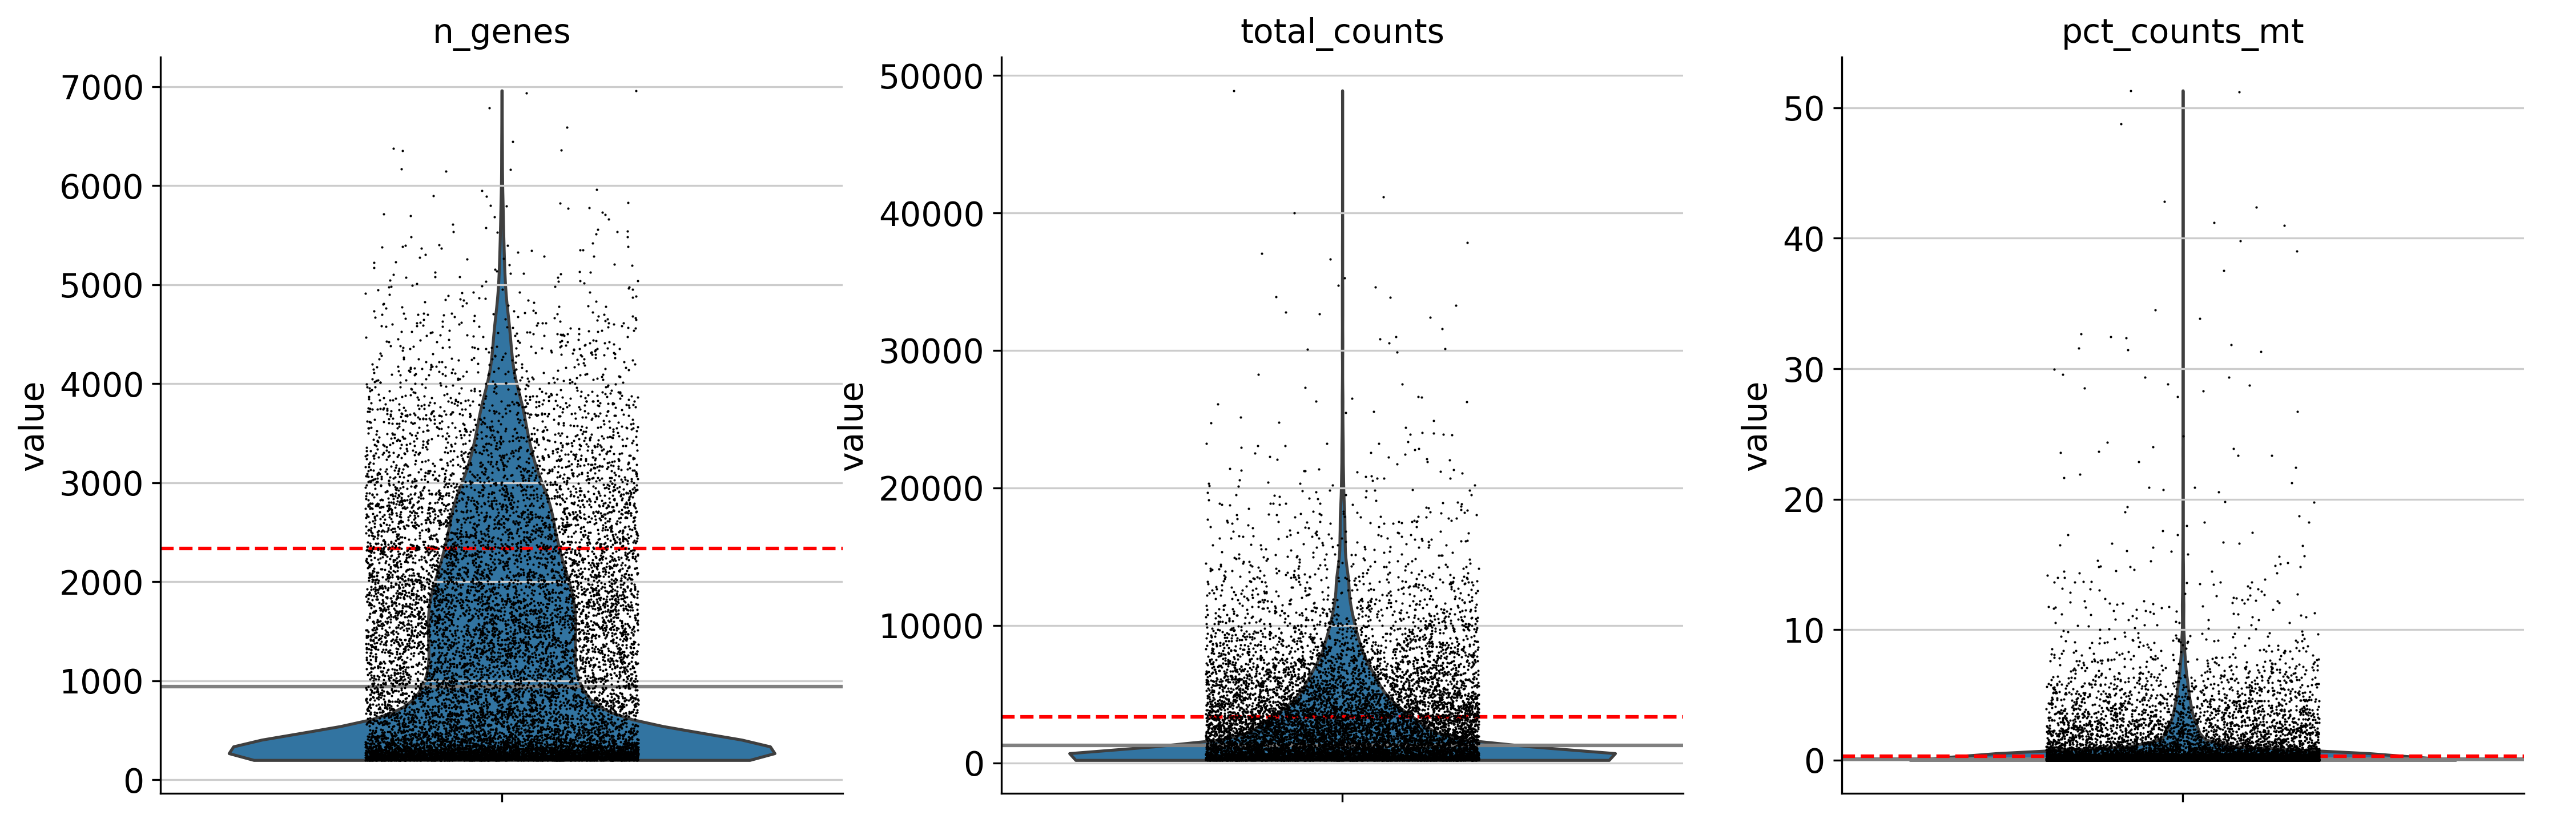

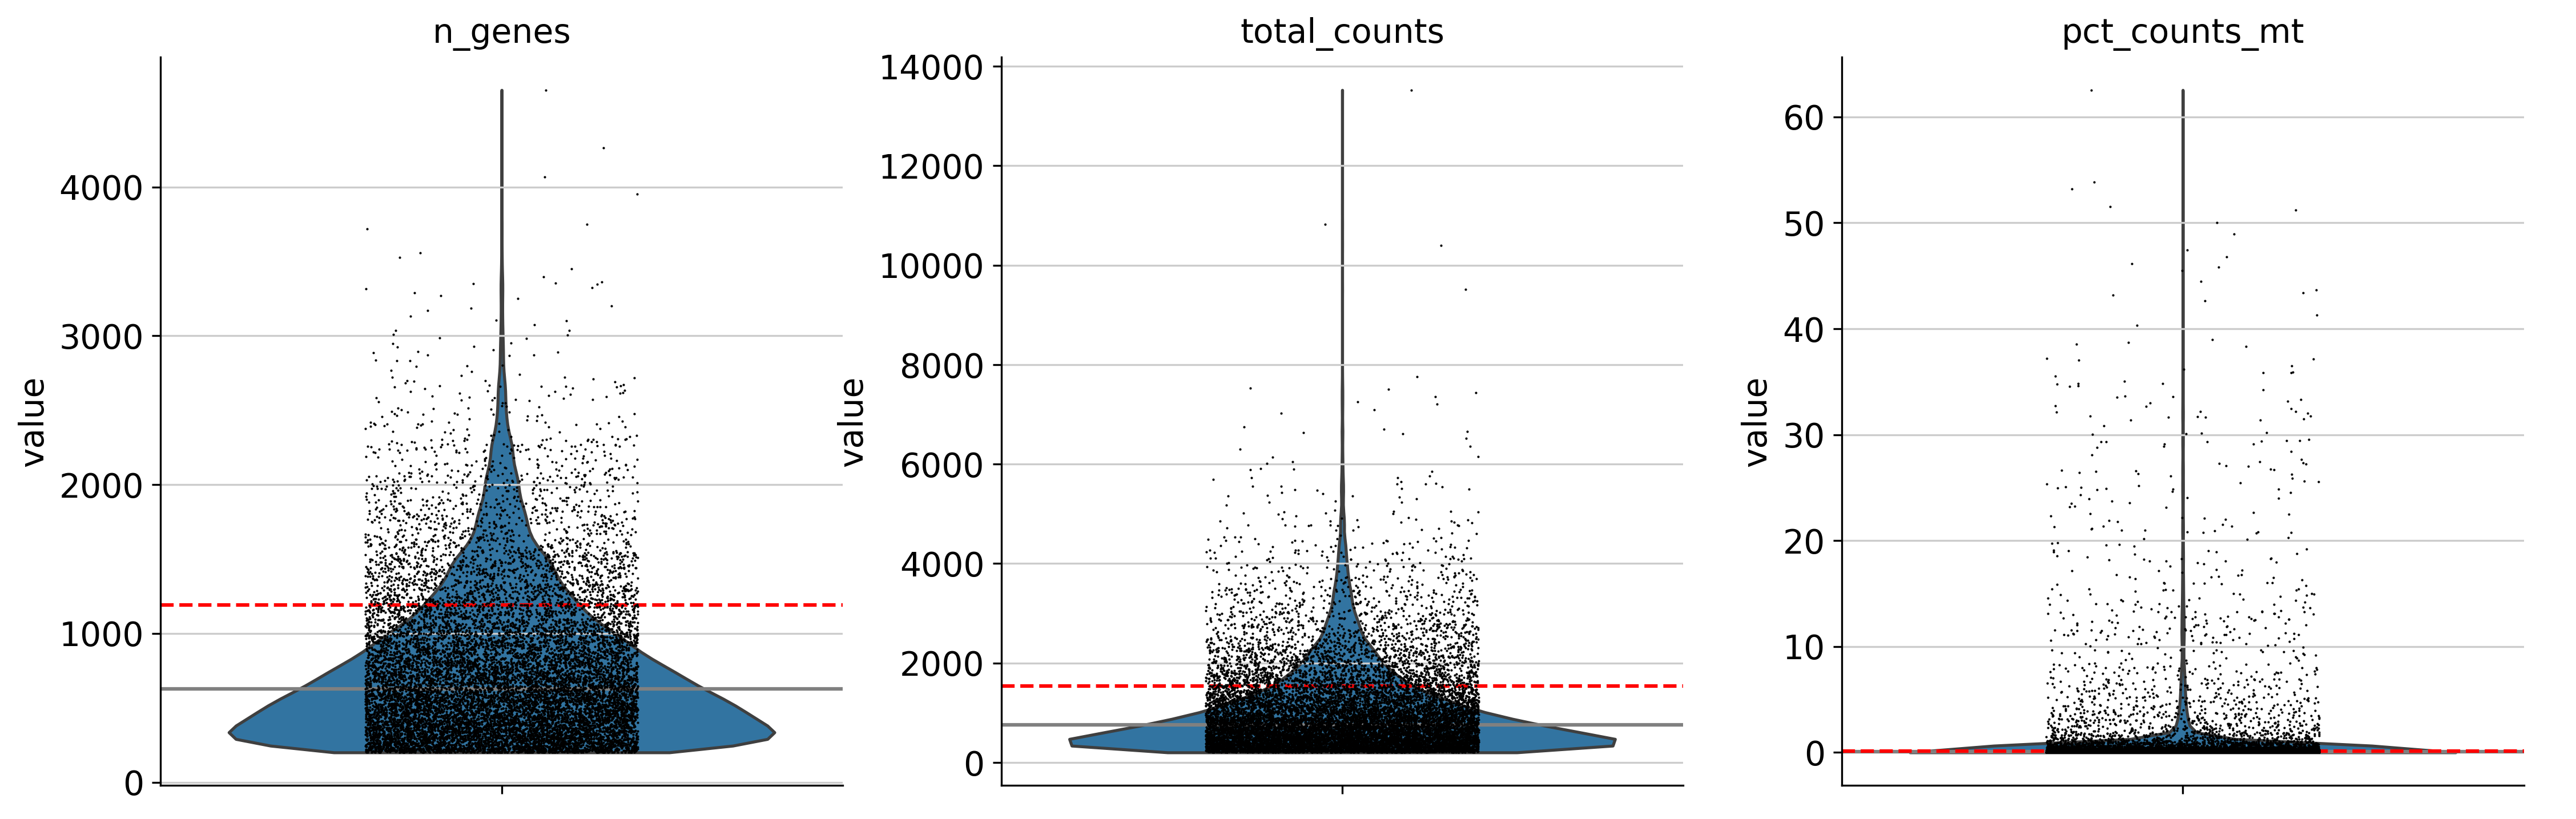

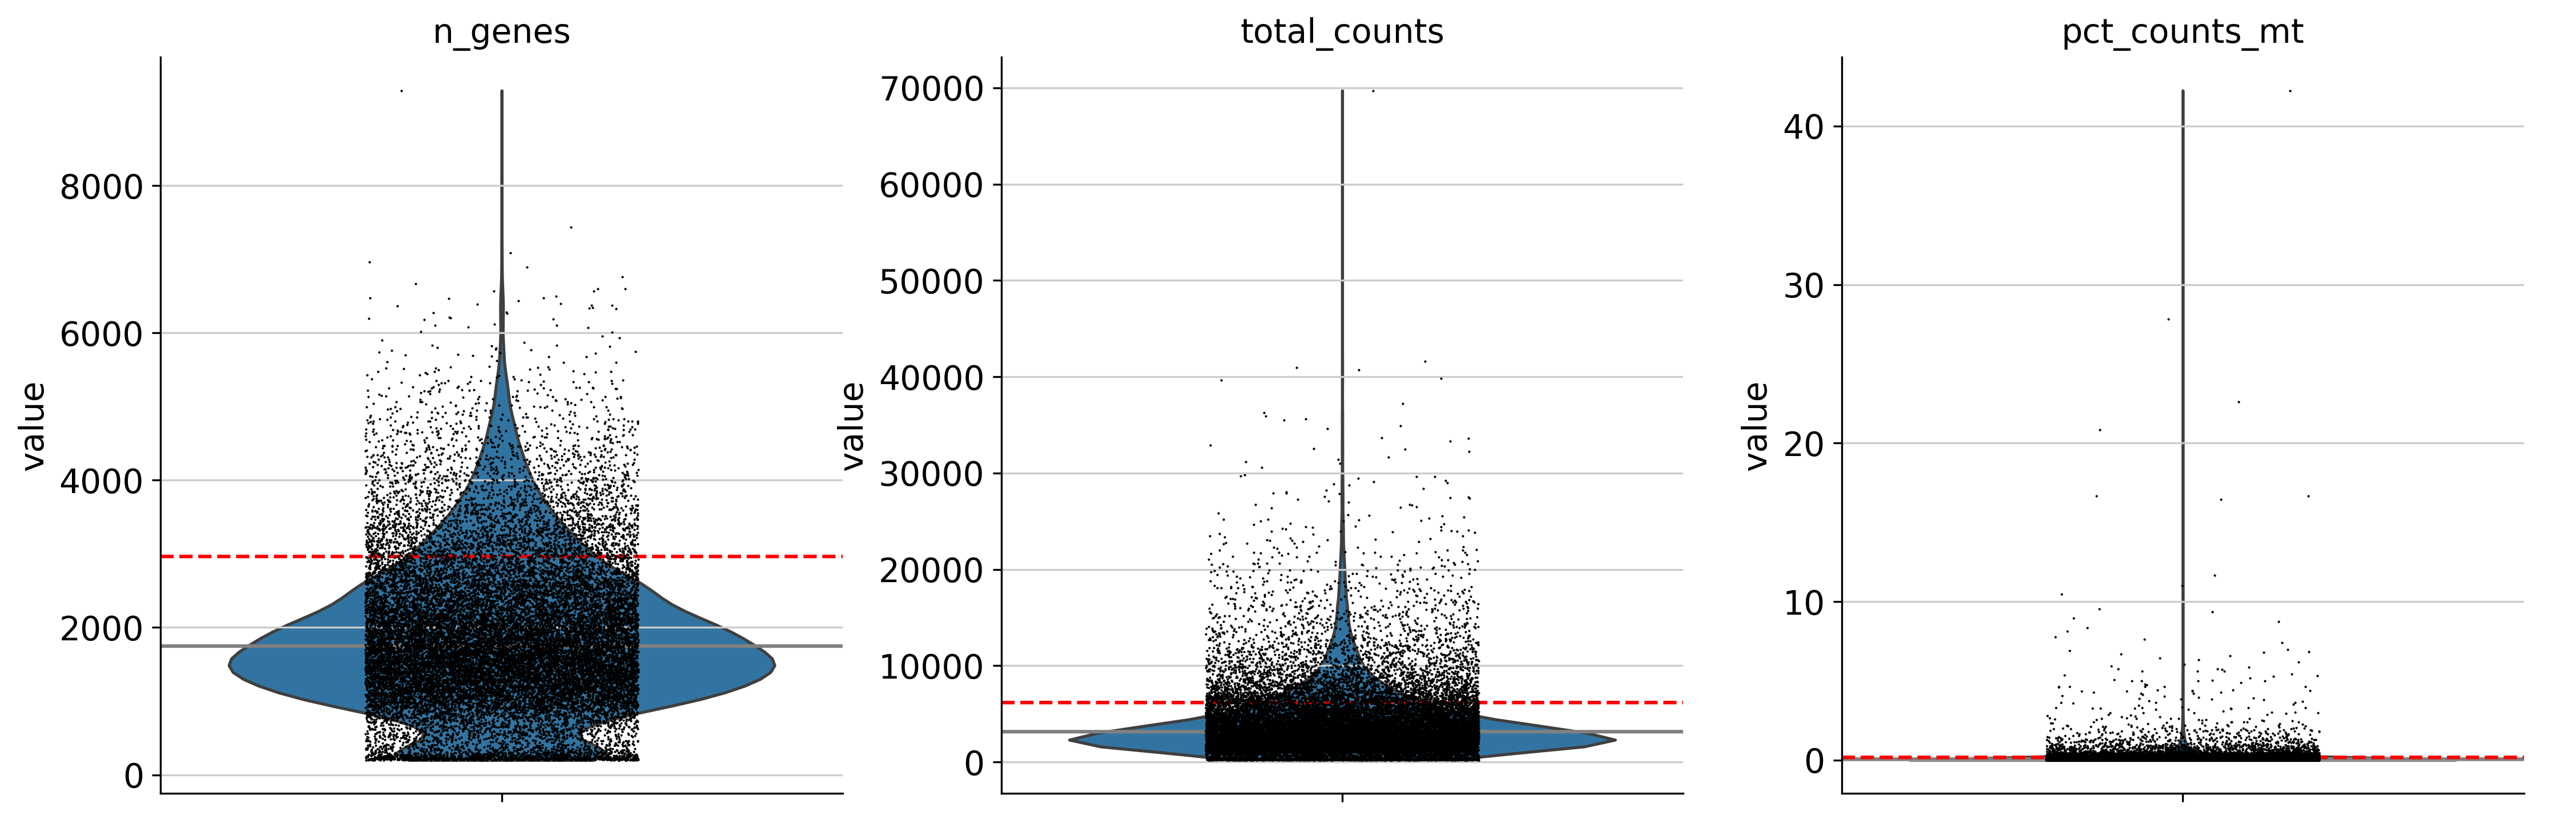

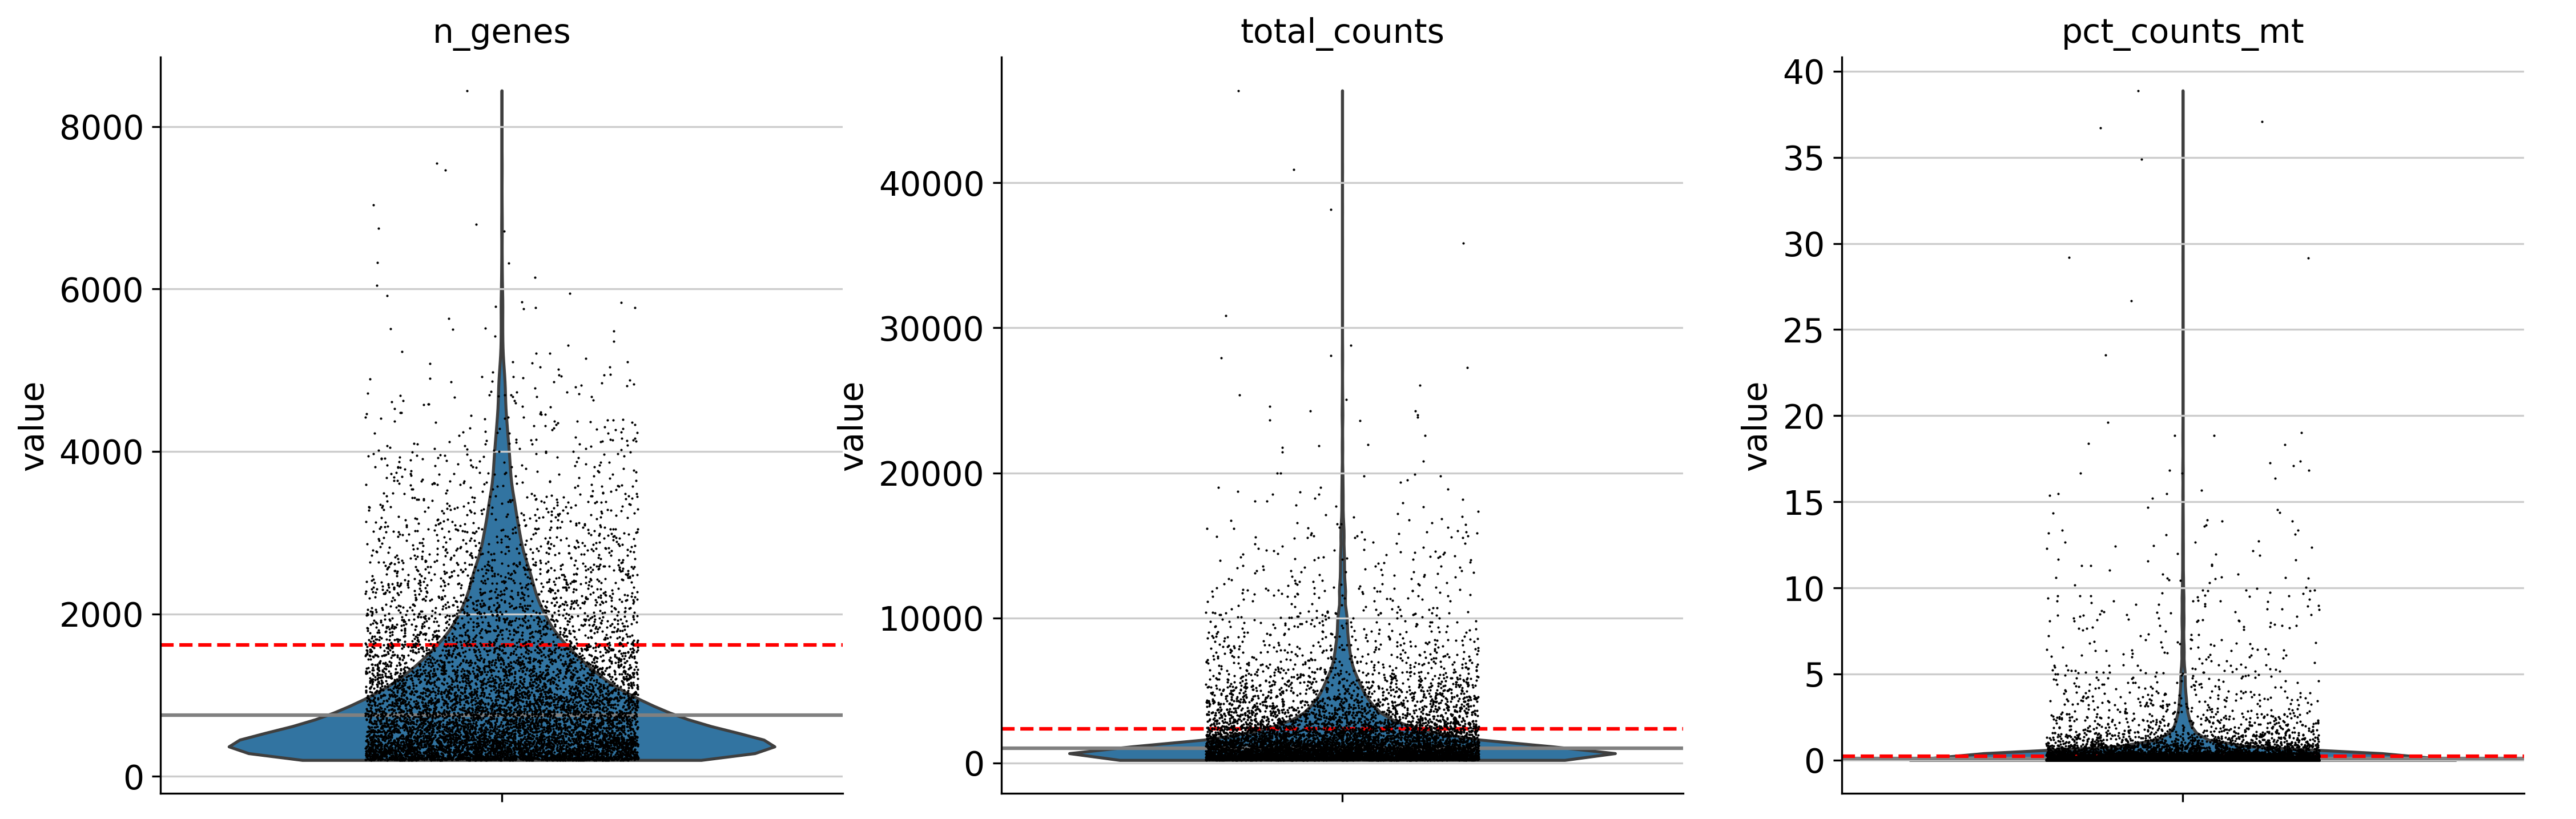

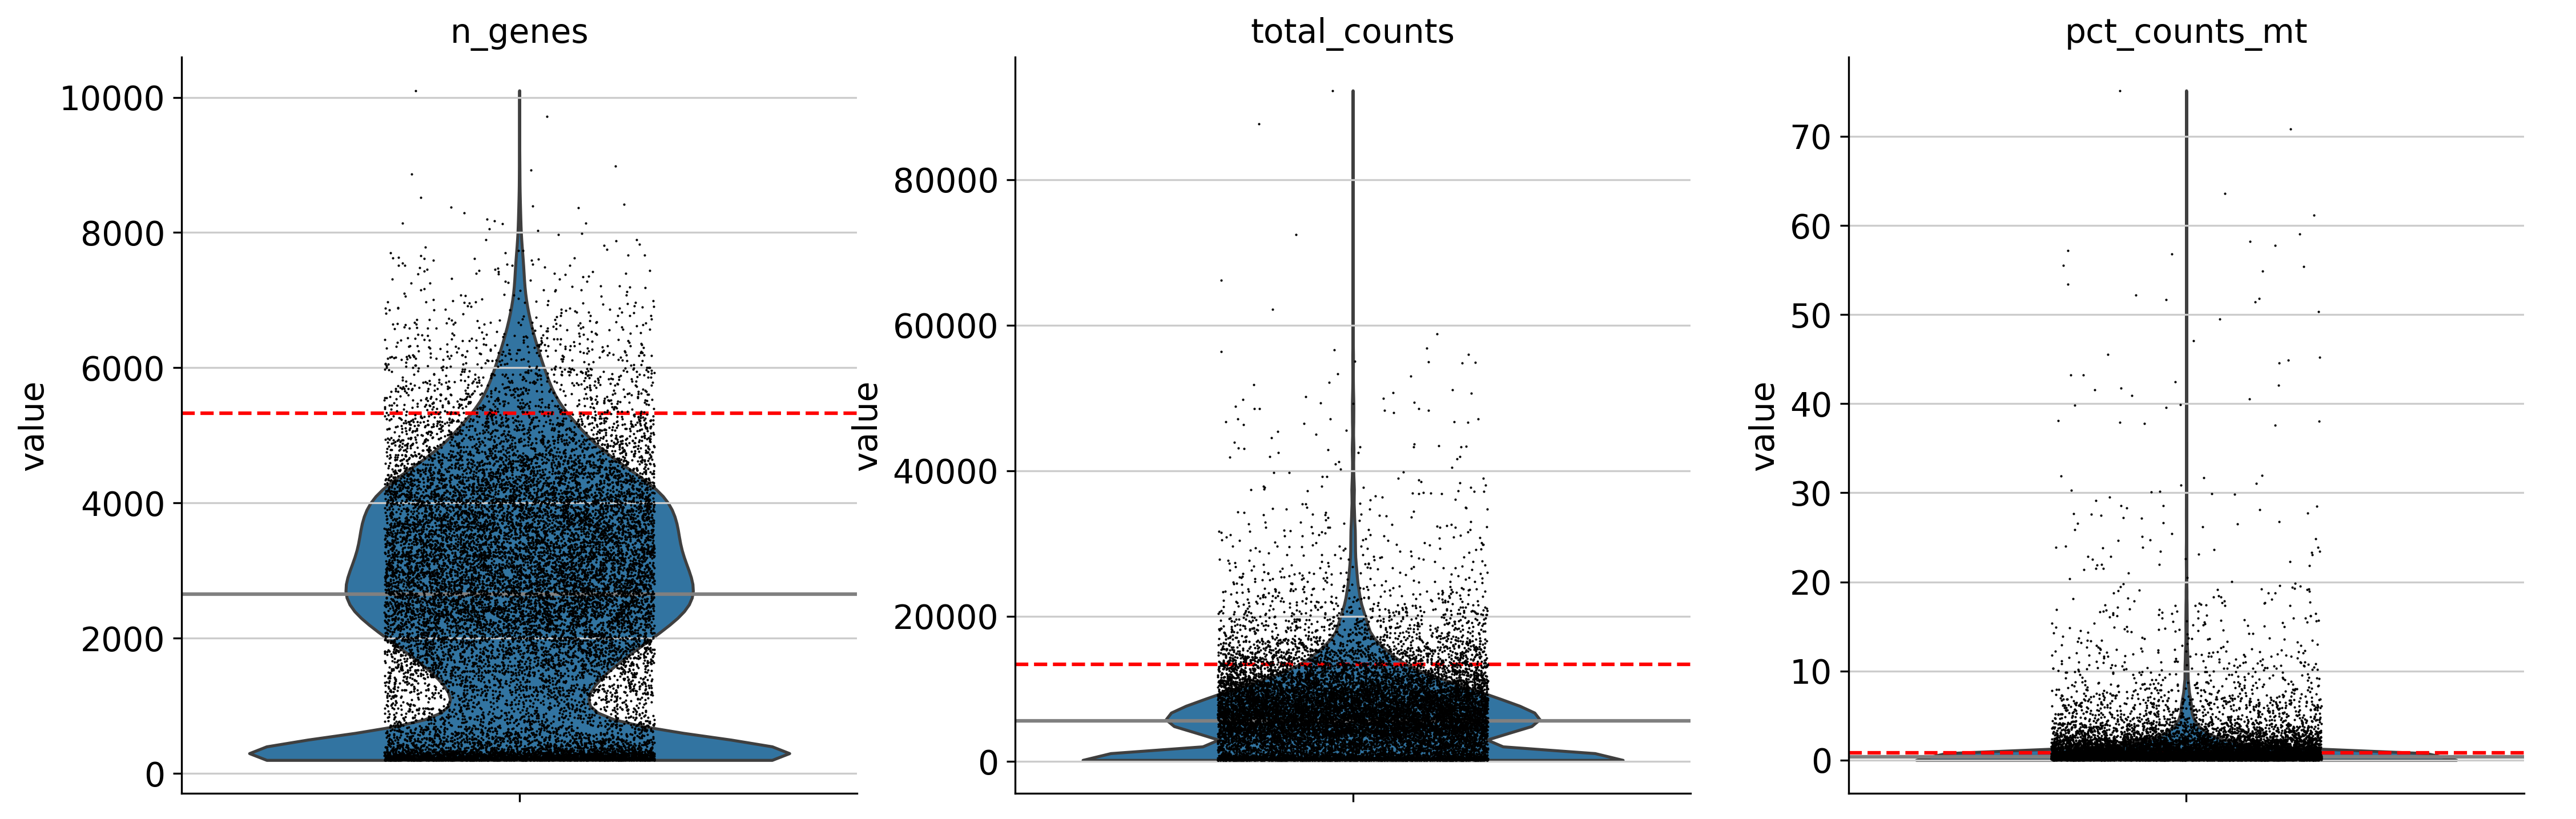

In [16]:
thresholds = {}
for k, adata in adata_list_selected.items():
    thresholds[k] = {}
    for f in features:
        thresholds[k][f] = mad_thresholds(adata.obs[f], 2)

for k, adata in adata_list_selected.items():
    print(k)
    ax = sc.pl.violin(adata, keys=features, jitter=0.2, multi_panel=True, show=False)
    for idx, feature in enumerate(features):
        ax.axes[0][idx].axhline(thresholds[k][feature]["median"], color='grey')
        ax.axes[0][idx].axhline(thresholds[k][feature]["upper_limit"], ls='--', color='red') # upper threshold

plt.show()

In [17]:
nmads=2
for k, adata in adata_list_selected.items():
    print(f"Processing: {k}") 
    adata.obs["outlier"] = (
        mad_filter(adata, "log1p_total_counts", nmads) | 
        mad_filter(adata, "log1p_n_genes_by_counts", nmads)
    )
    adata.obs["mt_outlier"] = (
        mad_filter(adata, "pct_counts_mt", nmads) | (adata.obs["pct_counts_mt"] > 8)
    )
    print(f"Total number of cells: {adata_list_selected[k].n_obs}")
    adata_list_selected[k] = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    print(f"Number of cells after filtering out low quality cells: {adata_list_selected[k].n_obs}")

Processing: C3N-01814
Total number of cells: 17046
Number of cells after filtering out low quality cells: 9697
Processing: C3N-00662
Total number of cells: 13518
Number of cells after filtering out low quality cells: 8482
Processing: C3N-02190
Total number of cells: 13620
Number of cells after filtering out low quality cells: 7328
Processing: C3N-02783
Total number of cells: 22508
Number of cells after filtering out low quality cells: 14874
Processing: C3N-03186
Total number of cells: 8871
Number of cells after filtering out low quality cells: 5194
Processing: C3N-03188
Total number of cells: 17663
Number of cells after filtering out low quality cells: 10708


In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    sc.pp.scrublet(adata)

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    print("Before filtering out doublets \n{}".format(adata.n_obs))

In [ ]:
for k, adata in adata_list_selected.items():
    adata_list_selected[k] = adata[~adata.obs["predicted_doublet"]].copy()

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    print("After filtering out doublets \n{}".format(adata.n_obs))

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    adata.raw = adata.copy()

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    adata.layers['counts'] = adata.X.copy()

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    sc.pp.normalize_total(adata,target_sum=1e4)
    adata.layers["normalized"] = adata.X.copy()
    sc.pp.log1p(adata)
    adata.layers["log1p"] = adata.X.copy()

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.pl.highly_variable_genes(adata)
    adata.var['original_highly_variable'] = adata.var['highly_variable']
    adata.var['highly_variable'] = np.logical_and(
        np.logical_xor(
            np.logical_or(
                adata.var['mt'], 
                adata.var['ribo']), 
            adata.var['highly_variable']),
        adata.var['highly_variable'])
    print("Selected {} HVG".format(np.sum(adata.var['highly_variable'])))

In [ ]:
path_to_list = "/group/iorio/Raffaele/Project_ADD3/review/TCGA/Single Cell/"

with open("".join([path_to_list,"S_phase.txt"])) as f:
    S_phase = [line.rstrip('\n') for line in f]

with open("".join([path_to_list,"G2M_phase.txt"])) as f:
    G2M_phase = [line.rstrip('\n') for line in f]

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    sc.tl.score_genes_cell_cycle(adata, g2m_genes=G2M_phase, s_genes=S_phase)

In [ ]:
# Scale data, compute PCA and visualize it for mito-ribo percents, number of genes-counts and cell cycle
for k, adata in adata_list_selected.items():
    print(k)
    sc.pp.scale(adata, max_value = 10)
    sc.pp.pca(adata, svd_solver = 'arpack', mask_var = "highly_variable")
    sc.pl.pca_scatter(adata, 
                      color = ['pct_counts_mt','pct_counts_ribo','n_genes','total_counts', 'S_score', 'G2M_score'], 
                      color_map = 'Purples', 
                      ncols = 4)

In [ ]:
covariates=["pct_counts_mt", "pct_counts_ribo", "n_genes", "total_counts", "S_score", "G2M_score"]
cc_dict = dict()
for k, adata in adata_list_selected.items():
    cc_dict[k]=dict()
    for cv in covariates:
        cc_dict[k][cv]=dict()
        for i in range(10):
            cc = np.corrcoef(adata.obsm["X_pca"][:, i], adata.obs[cv])[0, 1]
            cc_dict[k][cv][i]=cc
            
cc_df = pd.concat([pd.DataFrame(cc_dict[k]) for k in adata_list_selected.keys()], keys=samples)
cc_df > 0.5

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

n_pc = 5
results = {}
variance_expl = {}

for k, adata in adata_list_selected.items():
    print(f"Processing dataset: {k}")
    results[k] = {}
    pca_scores = pd.DataFrame(
        data=adata.obsm["X_pca"][:, :n_pc], 
        columns=[f"PC{i+1}" for i in range(n_pc)],
        index=adata.obs_names
    )
    data = pd.concat([pca_scores, adata.obs[covariates]], axis=1).dropna() 
    for pc in pca_scores.columns:
        formula = f"{pc} ~ " + " + ".join(covariates)
        model = ols(formula, data=data).fit()
        anova_results = anova_lm(model, typ=2)
        results[k][pc] = anova_results

for k, pcs in results.items():
    variance_expl[k] = {}
    for pc, anova_result in pcs.items():
        tot_variance = anova_result["sum_sq"].sum()
        cov_variance = anova_result["sum_sq"].iloc[:-1] 
        rss = anova_result["sum_sq"].iloc[-1]  
        unexplained = (rss / tot_variance) * 100  
        variance_expl[k][pc] = {
            "covariates": [(v / tot_variance) * 100 for v in cov_variance],
            "unexplained": unexplained
            }

for k, pcs in variance_expl.items():
    print(f"\nDataset: {k}")
    for pc, variances in pcs.items():
        print(f" Principal Component: {pc}")
        print(f"  Proportion of unexplained variance: {variances['unexplained']:.2f}%")
        for i, cov in enumerate(covariates):
            print(f"  Proportion of variance explained by '{cov}': {variances['covariates'][i]:.2f}%")

In [ ]:
df = pd.concat(
    [
        pd.DataFrame(
            [variance_expl[k][pc]["covariates"] for pc in variance_expl[k].keys()],
            columns=covariates,  
            index=variance_expl[k].keys()  
        )
        for k in variance_expl.keys()
    ],
    keys=samples  
)
df>5

In [ ]:
# Regressing out for the needed components
for k, adata in adata_list_selected.items():
    if(k=="C3N-01814"):
        print(k)
        sc.pp.regress_out(adata, ['total_counts', 'n_genes'], n_jobs=4)
    else:
        print(k)
        sc.pp.regress_out(adata, ['total_counts', 'n_genes', 'pct_counts_ribo'], n_jobs=4)
    

In [ ]:
covariates=["pct_counts_mt", "pct_counts_ribo", "n_genes", "total_counts", "S_score", "G2M_score"]
for k, adata in adata_list_selected.items():
    print(k)
    sc.pp.scale(adata, max_value = 10)
    sc.pp.pca(adata, svd_solver = 'arpack', mask_var="highly_variable")
    sc.pl.pca_scatter(
        adata, 
        color = covariates, 
        color_map = 'Purples', 
        ncols = 4)

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)     
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)     
    sc.tl.umap(adata, min_dist=0.3, spread=1.0)

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)     
    sc.pl.umap(adata, color = ['n_genes', 'pct_counts_ribo', 'pct_counts_mt', 'S_score', 'G2M_score'])

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)     
    for res in [0.2,0.4,0.6,0.7,0.8,0.9,1]:
        sc.tl.leiden(
            adata, 
            resolution=res, 
            random_state=2, 
            n_iterations=-1, 
            key_added='leiden_'+str(res))

In [ ]:
panels = dict()                                       
for k in adata_list_selected.keys():
    panels[k] = [x for x in adata_list_selected[k].obs.columns if x.startswith('leiden')]

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)     
    sc.pl.umap(adata, color = panels[k], ncols = len(panels[k])//2, show = False)
    plt.show()

In [ ]:
# Compute silhouette score using PCA embedding
silhouette_scores = dict()
for k, adata in adata_list_selected.items():
    print(k)     
    leiden_resolutions = [c for c in adata.obs.columns if "leiden" in c]
    # Initialize a nested dictionary for each dataset
    silhouette_scores[k] = dict()
    for res in leiden_resolutions:
        labels = adata.obs[res] 
        score = silhouette_score(adata.obsm['X_pca'], labels)
        silhouette_scores[k][res] = score
        #print(f" Resolution: {res}, Silhouette Score: {score}")

df = pd.DataFrame(silhouette_scores).T  # Transpose the DataFrame so datasets are rows, resolutions are columns
df = df.reset_index().melt(id_vars='index', var_name='Resolution', value_name='Silhouette Score')# Reset the index to get datasets as a column for plotting
df = df.rename(columns={'index': 'Dataset'})# Rename the index column to 'Dataset'

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Resolution', y='Silhouette Score', hue='Dataset')# Create a bar plot where each dataset and resolution pair has its own bar

plt.xticks(rotation=45)
plt.title('Silhouette Scores for Each Dataset and Resolution')
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [ ]:
resolutions = ['leiden_0.2', 'leiden_0.2', 'leiden_0.4', 'leiden_0.2', 'leiden_0.2', 'leiden_0.2']
for i, adata in enumerate(adata_list_selected.values()):
    print(k)     
    sc.pl.umap(adata, color=resolutions[i], title='', show=False, legend_loc='on data')
    sc.pl.umap(adata, color=covariates)
    sc.pl.umap(adata, color="ADD3", layer="log1p")
    plt.show()

In [ ]:
# Run Differential Analysis between clusters
#for i, adata in enumerate(adata_list_selected.values()):
#    print(i)
#    sc.tl.rank_genes_groups(adata, groupby = resolutions[i], n_genes = adata.n_vars, use_raw=True)
#for k, adata in adata_list_selected.items():
#    print(k)
#    sc.pl.rank_genes_groups(adata)
#    plt.show()
#deg_results = {}
#for k, adata in adata_list_selected.items():
#    clusters = adata.uns['rank_genes_groups']['names'].dtype.names
#    deg_results[k] = {
#        cl: pd.DataFrame({
#            'gene': adata.uns['rank_genes_groups']['names'][cl],
#            'logfoldchanges': adata.uns['rank_genes_groups']['logfoldchanges'][cl],
#            'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj'][cl]
#    }) for cl in clusters
#}
#for k in samples:
#    print(k)
#    pd.concat(deg_results[k]).to_csv(os.path.join(sc_data_path, k, "".join([k, "_TOT_DEGs.csv"])))

In [ ]:
#for k, adata in adata_list_selected.items():
    #print(k)
    #sc.pl.umap(adata, color='cell_type', legend_fontsize=10, legend_loc="on data",show=False)
    #plt.savefig(f"umap_plot_cell_type_{dir_list_reduced[i]}.png",dpi=300)
    #plt.close()
    #sc.pl.umap(adata, color=["CD34","CD44","SOX1","SOX2","NES","MSI2","CXCR4","L1CAM","CD70","S100A4","ALDH1A3","NANOG"])    

In [ ]:
for i, adata in enumerate(adata_list_selected.values()):
    print(samples[i])     
    sc.pl.umap(adata, color="ADD3", layer="log1p")
    sc.pl.umap(adata, color=resolutions[i],legend_loc='on data')
    plt.show()

In [ ]:
gsets=dict()
path2gmt='/group/iorio/Raffaele/Project_ADD3/review/Neftel_GBM.gmt.txt'
with open("".join([path2gmt])) as f:
    line_list = [line.strip().split('\t') for line in f]

In [ ]:
my_gsets_from_NEFTEL = {
    "MES1-like":line_list[0][2:len(line_list[0])],
    "MES2-like":line_list[1][2:len(line_list[1])],
    "AC-like":line_list[2][2:len(line_list[2])],
    "OPC-like":line_list[3][2:len(line_list[3])],
    "NPC1-like":line_list[4][2:len(line_list[4])],
    "NPC2-like":line_list[5][2:len(line_list[5])],
    "G1/S":line_list[6][2:len(line_list[6])],
    "G2/M":line_list[7][2:len(line_list[7])]}

my_gsets_from_NEFTEL

In [ ]:
data = []
for cell_type, genes in my_gsets_from_NEFTEL.items():
    for gene in genes:
        data.append([gene, cell_type])

annotations_df = pd.DataFrame(data, columns=["Gene", "Cell Type"])

print(annotations_df)

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    dc.run_ora(mat=adata,
               net=annotations_df,
               source='Cell Type',
               target='Gene',
               min_n=3,
               verbose=True,
               use_raw=False)

In [ ]:
acts_dict = dict()
for k, adata in adata_list_selected.items():
    print(f"Processing {k}")
    acts = dc.get_acts(adata, obsm_key='ora_estimate')
    # Flatten acts, find max finite value, and replace non-finite entries
    max_e = np.nanmax(acts.X[np.isfinite(acts.X)])
    acts.X = np.nan_to_num(acts.X, nan=max_e, posinf=max_e, neginf=max_e)
    # Store the processed acts in the dictionary
    acts_dict[k] = acts

In [ ]:
for i, acts in enumerate(acts_dict.values()):
    print(samples[i])
    sc.pl.umap(acts, color=resolutions[i], title='', show=False, legend_loc='on data')
    sc.pl.umap(acts, color=acts.obsm["ora_estimate"].columns, cmap='RdBu_r')
    plt.show()

In [ ]:
# Initialize dictionaries for storing results
df_list = []
ctypes_dict_list = {}
annotation_dict_list = {}

# Process each item in acts_dict and store results in respective dictionaries
n_ctypes = 3
for i, (sample, acts) in enumerate(acts_dict.items()):
    # Generate ranked data for each group
    df = dc.rank_sources_groups(acts, groupby=resolutions[i], reference='rest', method='t-test_overestim_var')
    df_list.append(df)
    # Extract top n_ctypes for each group
    ctypes_dict_list[sample] = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(list).to_dict()
    # Create a dictionary with top annotation for each group
    annotation_dict_list[sample] = df.groupby('group').head(1).set_index('group')['names'].to_dict()

In [ ]:
# Add cell type column based on annotation
for k, adata in adata_list_selected.items():
    print(k)
    adata.obs['cell_type'] = [annotation_dict_list[k][clust] for clust in adata.obs[resolutions[i]]]

In [ ]:
# Plot Umaps with cell types annotation
for k, adata in adata_list_selected.items():
    print(k)
    sc.pl.umap(adata, color='cell_type')

In [ ]:
for i, adata in enumerate(adata_list_selected.values()):
    print(samples[i])
    sc.tl.rank_genes_groups(adata, groupby="cell_type", n_genes = adata.n_vars, use_raw=True)

In [ ]:
for k, adata in adata_list_selected.items():
    print(k)
    sc.pl.rank_genes_groups(adata)
    plt.show()

In [ ]:
deg_results = {}
for k, adata in adata_list_selected.items():
    ctypes = adata.uns['rank_genes_groups']['names'].dtype.names
    deg_results[k] = {
        ct: pd.DataFrame({
            'gene': adata.uns['rank_genes_groups']['names'][ct],
            'logfoldchanges': adata.uns['rank_genes_groups']['logfoldchanges'][ct],
            'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj'][ct]
    }) for ct in ctypes
}

In [ ]:
df_list = []
for k, subdict in deg_results.items():
    for ct, subdf in subdict.items():
        subdf['sample'] = k
        subdf['cell_type'] = ct 
        df_list.append(subdf)

concatenated_deg_res = pd.concat(df_list, ignore_index=True)

In [ ]:
concatenated_deg_res.to_csv("/group/iorio/Raffaele/Project_ADD3/TOT_DEGs_CELL_TYPE_NEFTEL_bis.csv")

## Run pseudobulk analysis

In [ ]:
adata_combined = anndata.concat(
    adata_list_selected.values(),  
    label= "batch" 
)

In [ ]:
# Get filtered pseudo-bulk profile
pdata_all = dc.get_pseudobulk(
    adata_combined,
    sample_col='batch',
    groups_col='cell_type',
    layer="counts",
    mode='sum',
    min_cells=10,
    min_counts=1000
)

pdata_all.layers['counts'] = pdata_all.X.copy()

# Return raw counts to X
#dc.swap_layer(pdata_all, 'counts', X_layer_key=None, inplace=True)

In [ ]:
sc.pp.normalize_total(pdata_all,target_sum=1e4)
sc.pp.log1p(pdata_all)
sc.pp.highly_variable_genes(pdata_all, n_top_genes=2000)
sc.pp.pca(pdata_all, mask_var="highly_variable")
sc.pl.pca(pdata_all, color=['batch', 'cell_type'], ncols=1, size=300,s=50, marker='^')
sc.pl.pca_variance_ratio(pdata_all)

### ANOVA to test association of ADD3 expression with cell types

In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Extract expression values for the gene of interest
gene_expression = pdata_all[:, "ADD3"].X.A1 if hasattr(pdata_all[:, "ADD3"].X, "A1") else pdata_all[:, "ADD3"].X

# Combine expression data with cluster information
data = pd.DataFrame({
    'expression': gene_expression.flatten(),
    'cell_type': pdata_all.obs['cell_type']
})


groups = [group['expression'].values for name, group in data.groupby('cell_type')]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*groups)


# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(
    endog=data['expression'],    # Gene expression values
    groups=data['cell_type'],     # Cluster labels
    alpha=0.05                  # Significance level
)



print(f"ANOVA results: F-statistic = {f_stat}, P-value = {p_value}")
print(tukey)
# Visualize Tukey's test results
tukey.plot_simultaneous()
plt.savefig("/group/iorio/Raffaele/Project_ADD3/tukey_simultaneous_plot.pdf", dpi=300, bbox_inches="tight")

In [ ]:
# Create a boxplot with non-overlapping violins

plt.figure(figsize=(10, 5))
sns.boxplot(x='cell_type', y='expression', data=data, hue="cell_type")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.ylim(0,2.5)

# Add title and labels
plt.title("ADD3 Expression")
plt.ylabel("logCPM Expression")


# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
markers = {
    "GBM stem cells (GSC)" : ["CD133", "PROM1", "CD15", "FUT4", "ITGA6", "NES", "SOX2"],
    "Neural progenitor cells (NPC)" : ["NES", "SOX2", "VIM", "PAX6", "HES1", "HES5", "GFAP"],
    "Astrocytes" : ["GFAP", "NDRG2", "S100B", "GLUL", "SLC1A1", "SLC1A3", "APOE", "ALDH1L1"],
    "Neuronal" : ["NeuN", "RBFOX3", "MAP2", "TUBB3", "TBR1", "DLG4", "NEUROD1", "NEUROD6", "SYP", "SYT1","SNAP25","MPT","DLG5","DCX"],
    "Oligodendrocytes" : ["OLIG2", "CLDN11", "MOG", "MBP", "APOD", "OLIG1"],
    "Microglia": ["IBA1", "TMEM119", "PTPRC", "CD45", "AIF1", "CX3CR1", "CD68", "CD40"],
    "Basal radial glia (bRG)" : ["NES", "SOX2", "VIM", "PAX6", "HES1", "HES5", "HOPX", "TNC", "FAM107A"],
    "Glial progenitor cells (GPC)" : ["SOX9", "SOX10", "GFAP", "PDGFRA", "OLIG2", "OLIG1", "A2B5"],
    "S/G2 cycling cells" : ["MKI67","CENPF", "PCNS", "ATAD2", "TOP2A"],
    "Neuronal commitment" : ["EOMES", "TBR2", "NEUROG1","NEUROG2", "PPP1R17"]
}


In [ ]:
sub_markers = {}

for category, genes in markers.items():  
    valid_genes = [gene for gene in genes if gene in adata_combined.var_names]
    if valid_genes: 
        sub_markers[category] = valid_genes

for m in sub_markers.keys():
    print(m)
    sc.pl.dotplot(
        adata_combined,
        sub_markers[m],
        groupby="cell_type", 
        layer="log1p", 
        figsize=(12, 3)
    )

### Run DESEQ2 to derive lists of cell types DEGs at the pseudobulk level

In [ ]:
expression_data_all = pdata_all.layers["counts"]
df=pd.DataFrame(expression_data_all, index=pdata_all.obs_names, columns=pdata_all.var_names)
df.columns = pdata_all.var_names
df.index = pdata_all.obs_names

metadata = pd.DataFrame(pdata_all.obs["cell_type"])

# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

inference = DefaultInference(n_cpus=8)

pairwise_results = {}

# Perform deseq2 for each Target vs. Others
for target_ct in pdata_all.obs["cell_type"].unique():
    print(target_ct)
    # Create a binary grouping: target  vs. others
    metadata["binary_group"] = metadata["cell_type"].apply(lambda x: target_ct if x == target_ct else "Others")
    dds = DeseqDataSet(
        counts=df,
        metadata=metadata[["binary_group"]],
        design_factors='binary_group',
        refit_cooks=True,
        inference=inference)
    
    # Run deseq 
    dds.deseq2()
    
    # Get results
    results = DeseqStats(dds, contrast=["binary-group", target_ct, "Others"])
    results.summary()
    df_res = results.results_df
    df_res["target_ct"] = target_ct  # Add target group for reference
    
    # Store results
    pairwise_results[target_ct] = df_res

# Combine results for all groups into a single DataFrame
all_results = pd.concat(pairwise_results.values(), keys=pairwise_results.keys())

print(all_results.head())

In [ ]:
all_results.reset_index().drop("level_0",axis=1).to_csv("/group/iorio/Raffaele/Project_ADD3/DEGs_PSEUDOBULKS_CTYPE_TOTAL.csv")